# Problem 2: Non-Conjugate Inference

In the following we will implement, from scratch, Bayesian non-conjugate inference. The standard computational approach is to resort to Markov Chain Monte Carlo (MCMC) in order to sample from the posterior. In order to stress that MCMC is only one computational approach, although arguably the most appropriate for most real-world scenarios, in this notebook we will explore a few alternative numerical methods too.

The numerical challenge we will consider is the computation of the mean or expected value of a posterior distribution, $\mathbb{E}[\theta | \underline{Y} = \underline{y}]$. The posterior mean is an important quantity to know and, in applied problems, often has a real-world interpretation.

The numerical methods we consider are:

- Quadrature (Trapezoidal Rule)
- Monte-Carlo Integration
- Rejection Sampling

Since we are implementing everything from scratch, we will be implementing each of these numerical methods. We will also ensure that the Bayesian inference problem that we consider is sufficiently simple to be amenable to these methods.

### Notebook settings

The following changes the default plot size for the notebook:

In [1]:
options(repr.plot.width = 4, repr.plot.height = 2.5)

### Loading Libraries

The following loads the required packages to run all the code in this notebook:

In [2]:
# install.packages(c("ggplot2", "cowplot"))

library(ggplot2)
library(cowplot)

## The Inference Problem

The particular inference problem we consider is one-dimensional parameter problem: inferring the rate parameter $\lambda$ of an Exponential distribution $\text{Exp}(\lambda)$.

### Data Generation

Similar to the last problem, we will use artificial data.

In [3]:
true_rate <- 2.3
n <- 20 # number of data points

y_data <- rexp(n, rate = true_rate)
print(y_data)

 [1] 0.05238089 0.32523292 1.45806955 0.15365990 0.54620064 0.30965061
 [7] 0.20567626 0.57926259 0.10291455 0.18389709 0.34906749 0.69374282
[13] 0.20359623 0.24458622 0.22548707 0.32089889 0.37617037 0.13450346
[19] 0.25559360 0.26712385


### Defining the Likelihood

The density function of an exponentially distributed random variable $Y_i \sim \text{Exp}(\lambda)$ takes the form 

$$ p(y_i|\lambda) = \lambda \exp\{-\lambda y_i\}.$$

Implementing this as a log density:

$$ \log p(y_i|\lambda) = \log(\lambda) - \lambda y_i.$$


In [4]:
matthews_dexp <- function(y_i, lambda, log = FALSE) {
    output <- log(lambda) - lambda * y_i
    if (log == TRUE) {
        return(output)
    }
    else{
        return(exp(output))
    }
}

#### Defining the full likelihood

Assuming $n$ IID observations, the full likelihood function takes the form

$$ p(\underline{y}|\lambda) = \prod_{i=1}^{n} \lambda \exp\{-\lambda y_i\}. $$

The log-likelihood then takes the form:

$$ \log p(\underline{y}|\lambda) = \sum_{i=1}^{n} \log(\lambda) -\lambda y_i. $$

In [5]:
dlikelihood <- function(y, lambda, log = FALSE) {
    output <- sum(matthews_dexp(y, lambda, log = TRUE))
    if (log == TRUE) {
        return(output)
    }
    else {
        return(exp(output))
    }
}

# If we want to evaluate the likelihood for a bunch
# of parameter values at once, we need to vectorise it.
# There are many ways to do this, one of which is the following:

dlikelihood_vectorised <- function(y, lambda, log = FALSE) {
    output <- sapply(lambda, function(lambda) dlikelihood(y, lambda, log = log))
    return(output)
}

### Defining the Prior

For the sake of ensuring lack of conjugacy, we will take our prior to follow a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). A log-normal distribution is the distribution of $\exp(X)$, whenever $X$ is normally distributed. That is, if $\lambda \sim \text{LogNormal}(\mu,\sigma^2)$, then $\log(\lambda) \sim \mathcal{N}(\mu,\sigma^2)$. Hence the name "log-normal". 

Since it is the exponential of a normal distribution, a log-normally distributed random variable is guaranteed to be positive. This is helpful since we know, *a priori*, that the rate parameter $\lambda$ is greater than $0$. 

We take the prior $\lambda \sim \text{LogNormal}(\mu, \sigma^2)$. The density is log-density are available in closed form:

$$ p(\lambda) = \frac{1}{\lambda\sigma\sqrt{2\pi}} \exp\left(-\frac{1}{2}\left(\frac{\log(\lambda) - \mu}{\sigma}\right)^2\right),$$
$$ \log p(\lambda) = -\log \lambda - \log \sigma\sqrt{2\pi} -\frac{1}{2}\left(\frac{\log(\lambda) - \mu}{\sigma}\right)^2.$$

In [6]:
dprior <- function(lambda, prior_params, log = FALSE) {
    mu <- prior_params$mu # assign each parameter from the vector
    sd <- prior_params$sd

    constant <- - log(sd) - 0.5 * log(2 * pi)
    first_term <- - log(lambda)
    exp_term <- - 0.5 * ((log(lambda) - mu) / sd) ** 2

    output <- constant + first_term + exp_term

    if (log == TRUE) {
        return(output)
    }
    else {
        return(exp(output))
    }
}

#### Plotting our Prior

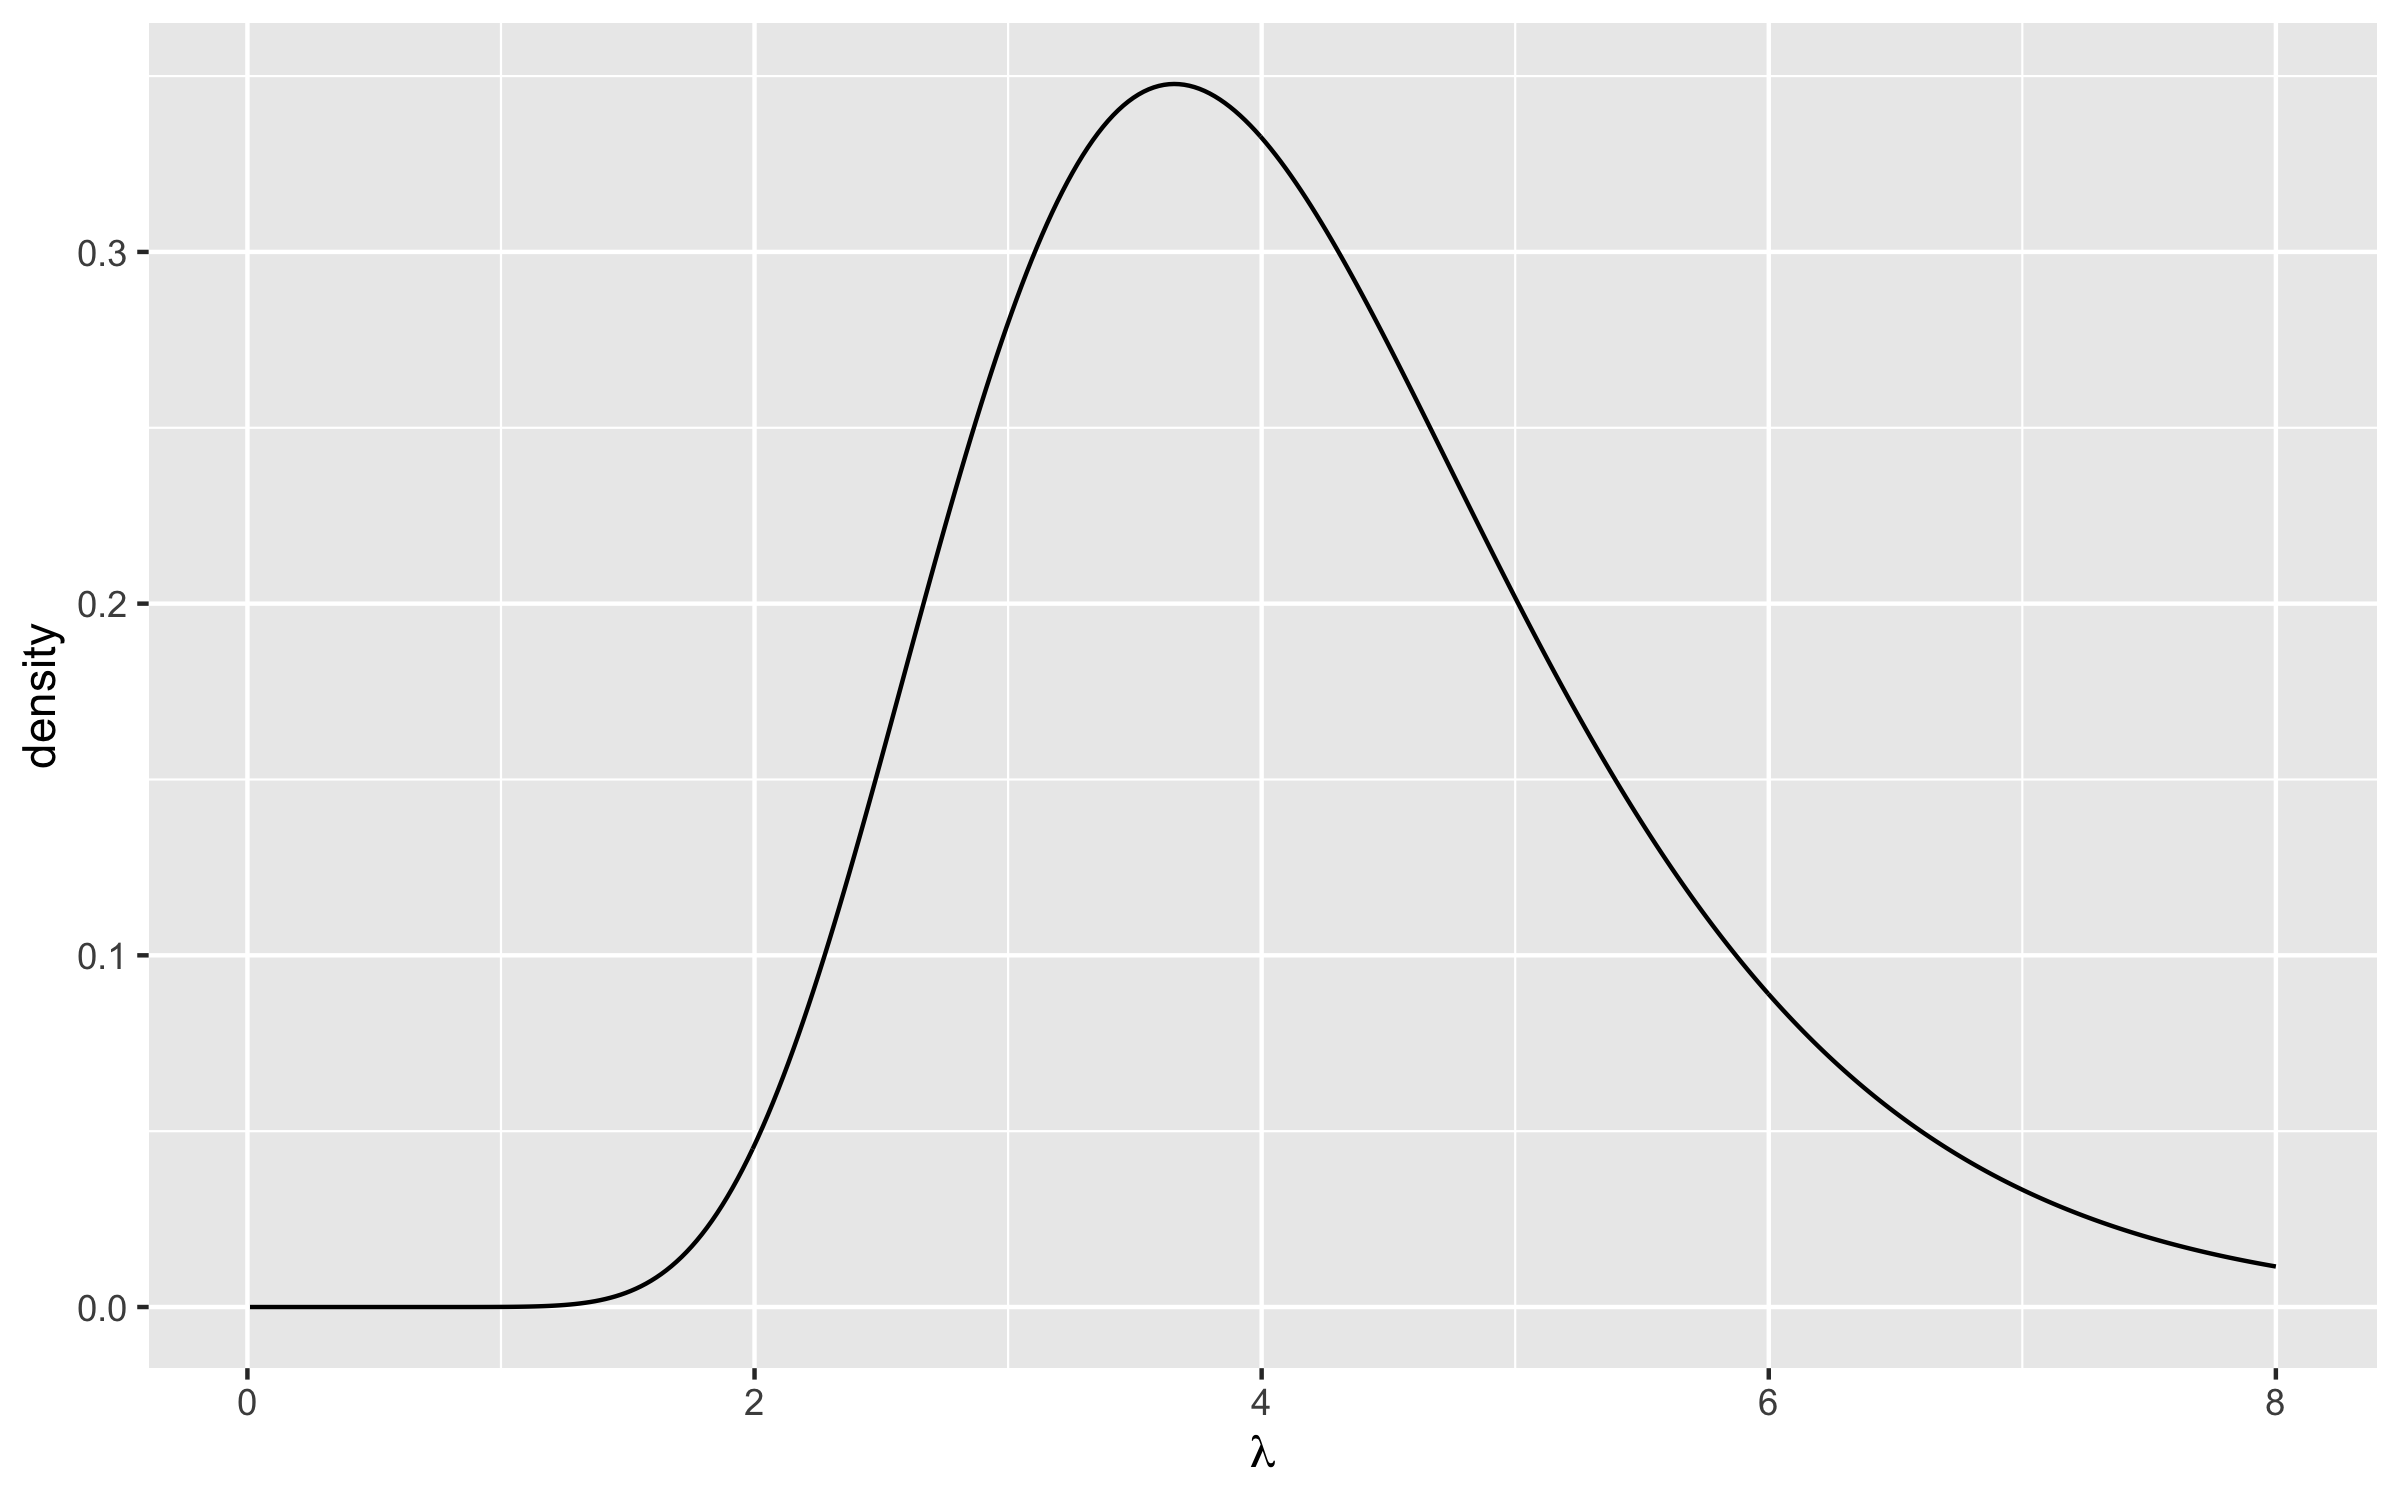

In [7]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)

lambda_mesh <- seq(0.01, 8, length.out = 400) # define x mesh
prior_eval <- dprior(lambda_mesh, list(mu = log(4), sd = 0.3)) # mean = 1, standard_deviation = 0.4

gg_plot_df <- data.frame(y = lambda_mesh, density = prior_eval)

prior_plot <- ggplot(gg_plot_df, aes(x = y, y = density)) +
                   geom_line() + xlab(expression(lambda))
prior_plot

### The Bayesian Update

In the following implementation, ``dposterior`` evaluates the unnormalised posterior

$$ \tilde{p}(\lambda | \underline{y}) = p(\underline{y}|\lambda)p(\lambda), $$

where the data used, ``y_data``, and prior parameters, ``prior_params``, are kept as arguments.

In [8]:
dposterior <- function(lambda, y_data, prior_params, log = FALSE) {
    log_prior <- dprior(lambda, prior_params = prior_params, log = TRUE)
    log_likelihood <- dlikelihood_vectorised(y_data, lambda, log = TRUE)

    output <- log_prior + log_likelihood

    if (log == TRUE) {
        return(output)
    }
    else {
        return(exp(output))
    }
}

#### Plotting the Unnormalised Posterior

In order to investigate the sensitivity of the Bayesian update to the amount of data and prior specification, let's condition on different data and use different prior parameters. 

Feel free to vary the variables ``true_rate`` (the actual $\lambda$ value the data is generated from), ``n`` (the amount of data), ``mu`` and ``sd`` (parameters controlling the prior) and see how they affect the Bayesian updating.

In [24]:
true_rate <- 2.3
n <- 8 # number of data points

# y_data <- rexp(n, rate = true_rate)
print(y_data)

prior_params <- list(mu = log(4), sd = 0.5)

print(prior_params)

 [1] 0.05238089 0.32523292 1.45806955 0.15365990 0.54620064 0.30965061
 [7] 0.20567626 0.57926259 0.10291455 0.18389709 0.34906749 0.69374282
[13] 0.20359623 0.24458622 0.22548707 0.32089889 0.37617037 0.13450346
[19] 0.25559360 0.26712385
$mu
[1] 1.386294

$sd
[1] 0.5



Let's plot the likelihood, prior and the posterior altogether:

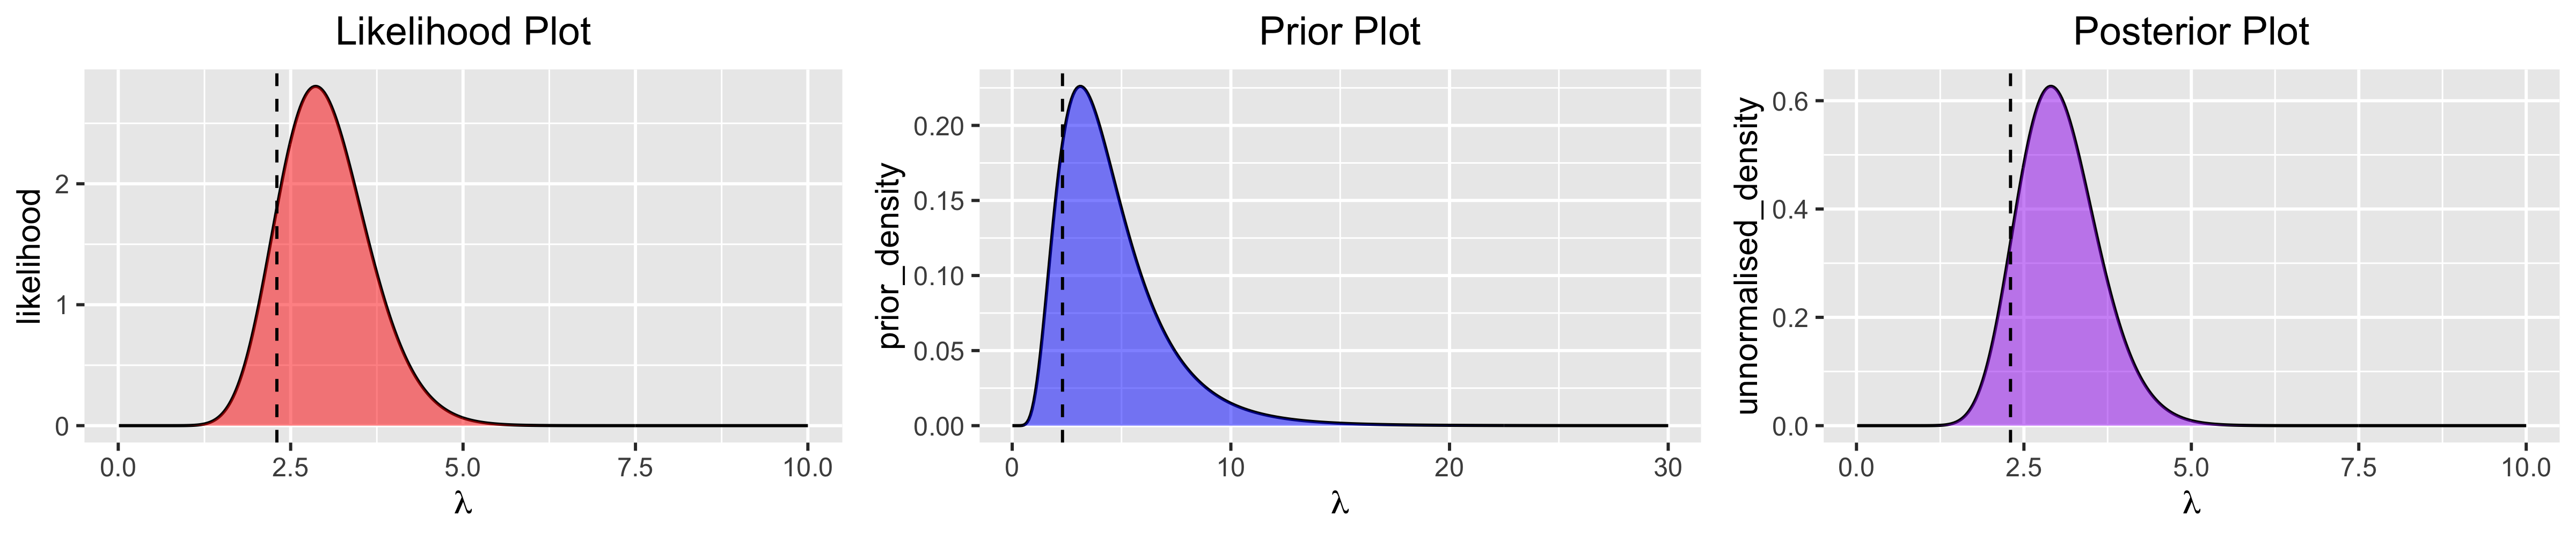

In [25]:
options(repr.plot.width = 12, repr.plot.height = 2.5, repr.plot.res = 400)

lambda_mesh <- seq(0.01, 10, length.out = 400) # define mesh
lambda_mesh_prior <- seq(0.01, 30, length.out = 400)

likelihood_eval <- dlikelihood_vectorised(y_data, lambda_mesh)
prior_eval <- dprior(lambda_mesh_prior, prior_params = prior_params)
posterior_eval <- dposterior(lambda_mesh, y_data, prior_params = prior_params)

prior_like_post_df <- data.frame(x = lambda_mesh, likelihood = likelihood_eval,
                                 prior_density = prior_eval,
                                 unnormalised_density = posterior_eval,
                                 min = numeric(400))

likelihood_plot <- ggplot(prior_like_post_df, aes(x = x, y = likelihood, ymin = min, ymax = likelihood)) +
                   geom_line() +
                   geom_ribbon(fill = "red", alpha = 0.5) +
                   ggtitle("Likelihood Plot") +
                   theme(plot.title = element_text(hjust = 0.5)) +
                   xlab(expression(lambda)) +
                   geom_vline(xintercept = true_rate, linetype = "dashed")

prior_plot <- ggplot(prior_like_post_df, aes(x = lambda_mesh_prior, y = prior_density, ymin = min, ymax = prior_density)) +
                   geom_line() +
                   geom_ribbon(fill = "blue", alpha = 0.5) +
                   ggtitle("Prior Plot") +
                   theme(plot.title = element_text(hjust = 0.5)) +
                   xlab(expression(lambda)) +
                   geom_vline(xintercept = true_rate, linetype = "dashed")

posterior_plot <- ggplot(prior_like_post_df, aes(x = x, y = unnormalised_density, ymin = min, ymax = unnormalised_density)) +
                   geom_line() +
                   geom_ribbon(fill = "purple", alpha = 0.5) +
                   ggtitle("Posterior Plot") +
                   theme(plot.title = element_text(hjust = 0.5)) +
                   xlab(expression(lambda)) +
                   geom_vline(xintercept = true_rate, linetype = "dashed")


plot_grid(likelihood_plot, prior_plot, posterior_plot, nrow = 1)

## The Numerical Challenge: Computing The Posterior Mean

The mean of the posterior distribution is an important quantity and is the integral:

$$ \mathbb{E}[\theta | \underline{y}] = \int_{\Theta} \theta p(\theta | \underline{y})\, \mathrm{d}\theta. $$

Since we are in the non-conjugate setting, the computation of this integral also requires the computation of the normalisation constant (denoted $C$):

$$ \mathbb{E}[\theta | \underline{y}] = \int_{\Theta} \theta \frac{p(\underline{y}|\theta)p(\theta)}{\int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta  }\, \mathrm{d}\theta =  \underbrace{\frac{1}{\int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta}}_{1/C}\int_{\Theta} \theta \underbrace{p(\underline{y}|\theta)p(\theta)}_{\text{Unnormalised Posterior}} \, \mathrm{d}\theta. $$

Here, we just used the definition of the posterior distribution through Bayes formula and moved the normalisation constant outside the integral (since it is a constant). 

We will soon see how if we are able to sample from the posterior distribution, we can estimate this posterior mean without the computation of the normalisation constant. Some sampling methods, such as Markov Chain Monte Carlo (MCMC) methods, are able to sample from $p(\theta|\underline{y})$ without the value of $C$ being given. 

In the following, we will compare a few approaches for the computation of the posterior mean of the non-conjugate Bayesian inference problem we specified above.

## Quadrature: The Trapezium Rule

Our first approach of computing the posterior mean is by using a quadrature method known as the trapezium rule. 

Suppose we want to compute the integral 

$$ I = \int_a^b f(x)  \,\mathrm{d}x.$$

For example, in the following, we are integrating the function

$$ f(x) = \exp(\sin(1/x)) $$

from $x = 0.1$ to $x = 0.4$.

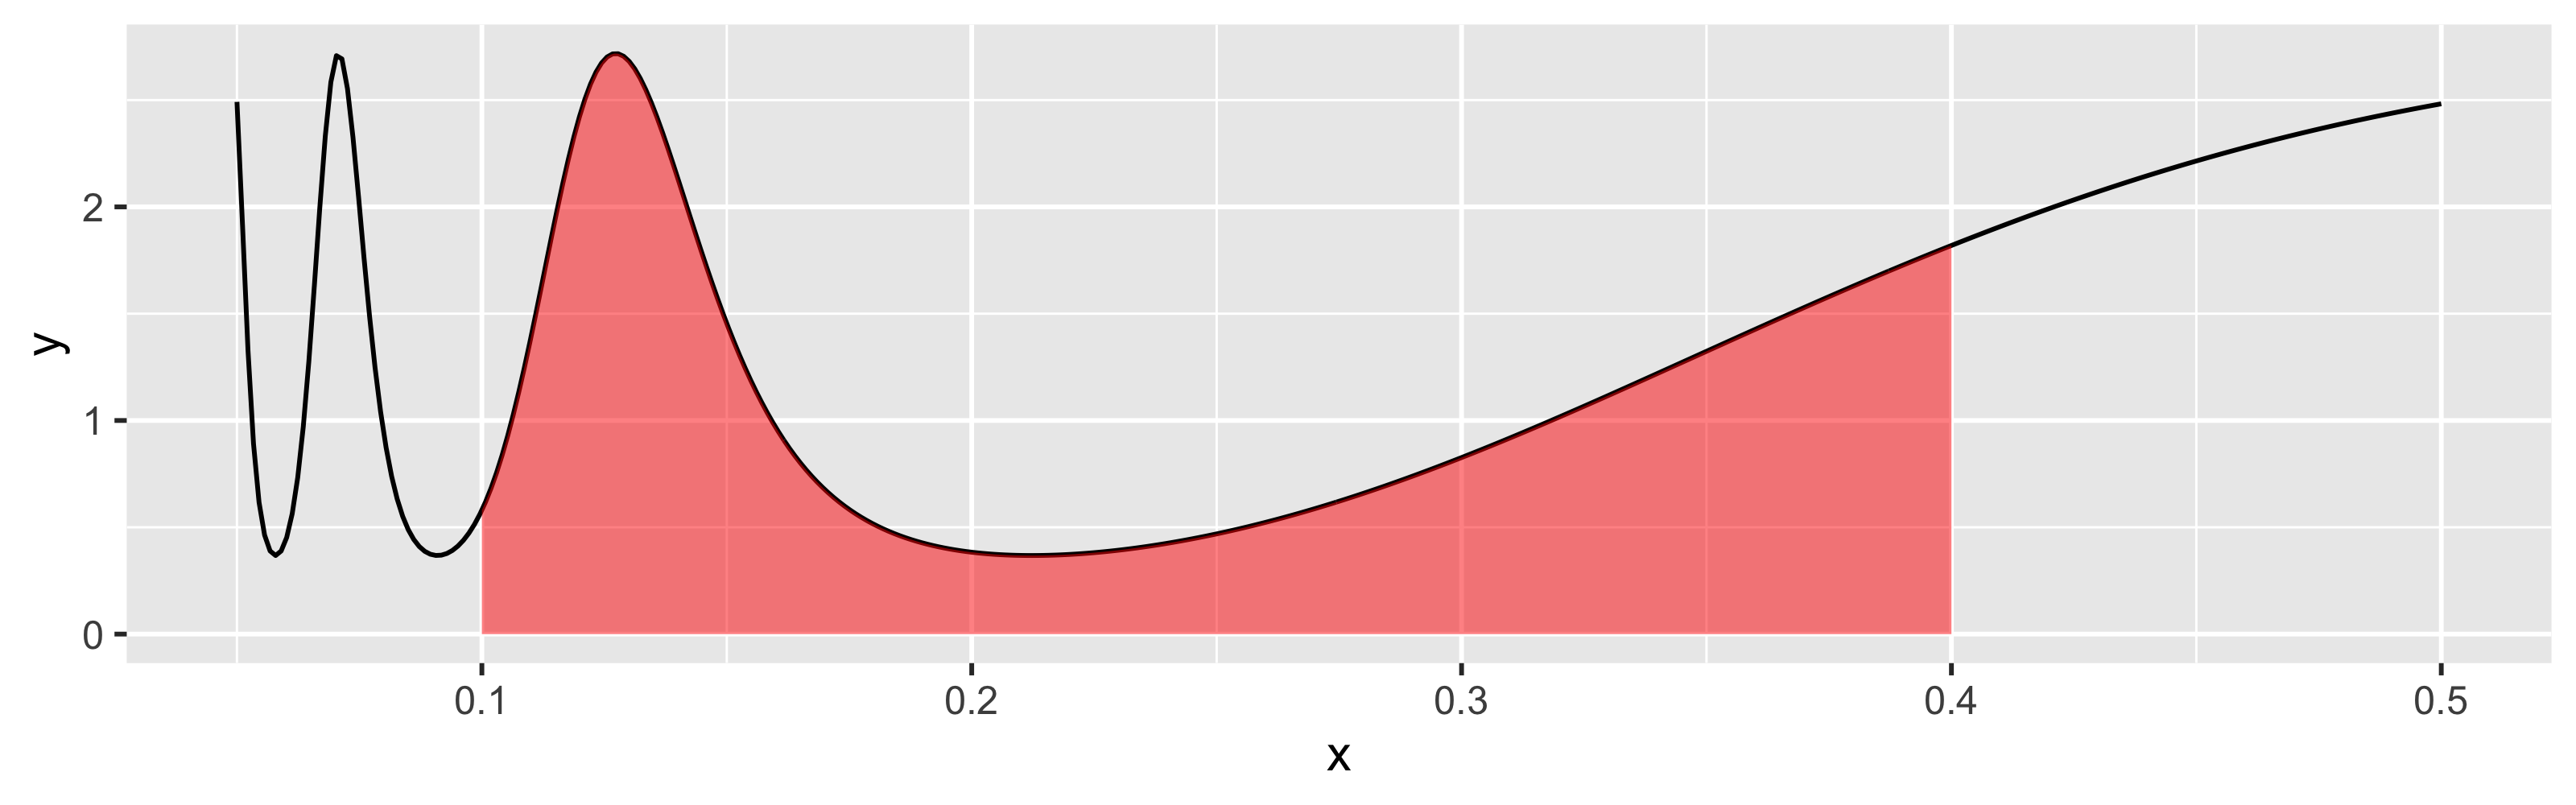

In [26]:
options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 400)

example_f <- function(x) {
    output <- exp(sin(1 / x))
    return(output)
    }

x_mesh <- seq(0.05, 0.5, length.out = 400) # define x mesh
x_int_mesh <- seq(0.1, 0.4, length.out = 400)

gg_plot_df <- data.frame(x = x_mesh, y = example_f(x_mesh),
                        x_int = x_int_mesh, ymin = numeric(400),
                        ymax = example_f((x_int_mesh)))

ggplot(gg_plot_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x_int, ymin = ymin, ymax = ymax),
        fill = "red", alpha = 0.5)

Quadrature proceeds by approximating the integral using evaluations $f(x_1),\ldots, f(x_n)$ at locations $x_1,\ldots, x_n$ by the construction an interpolant:

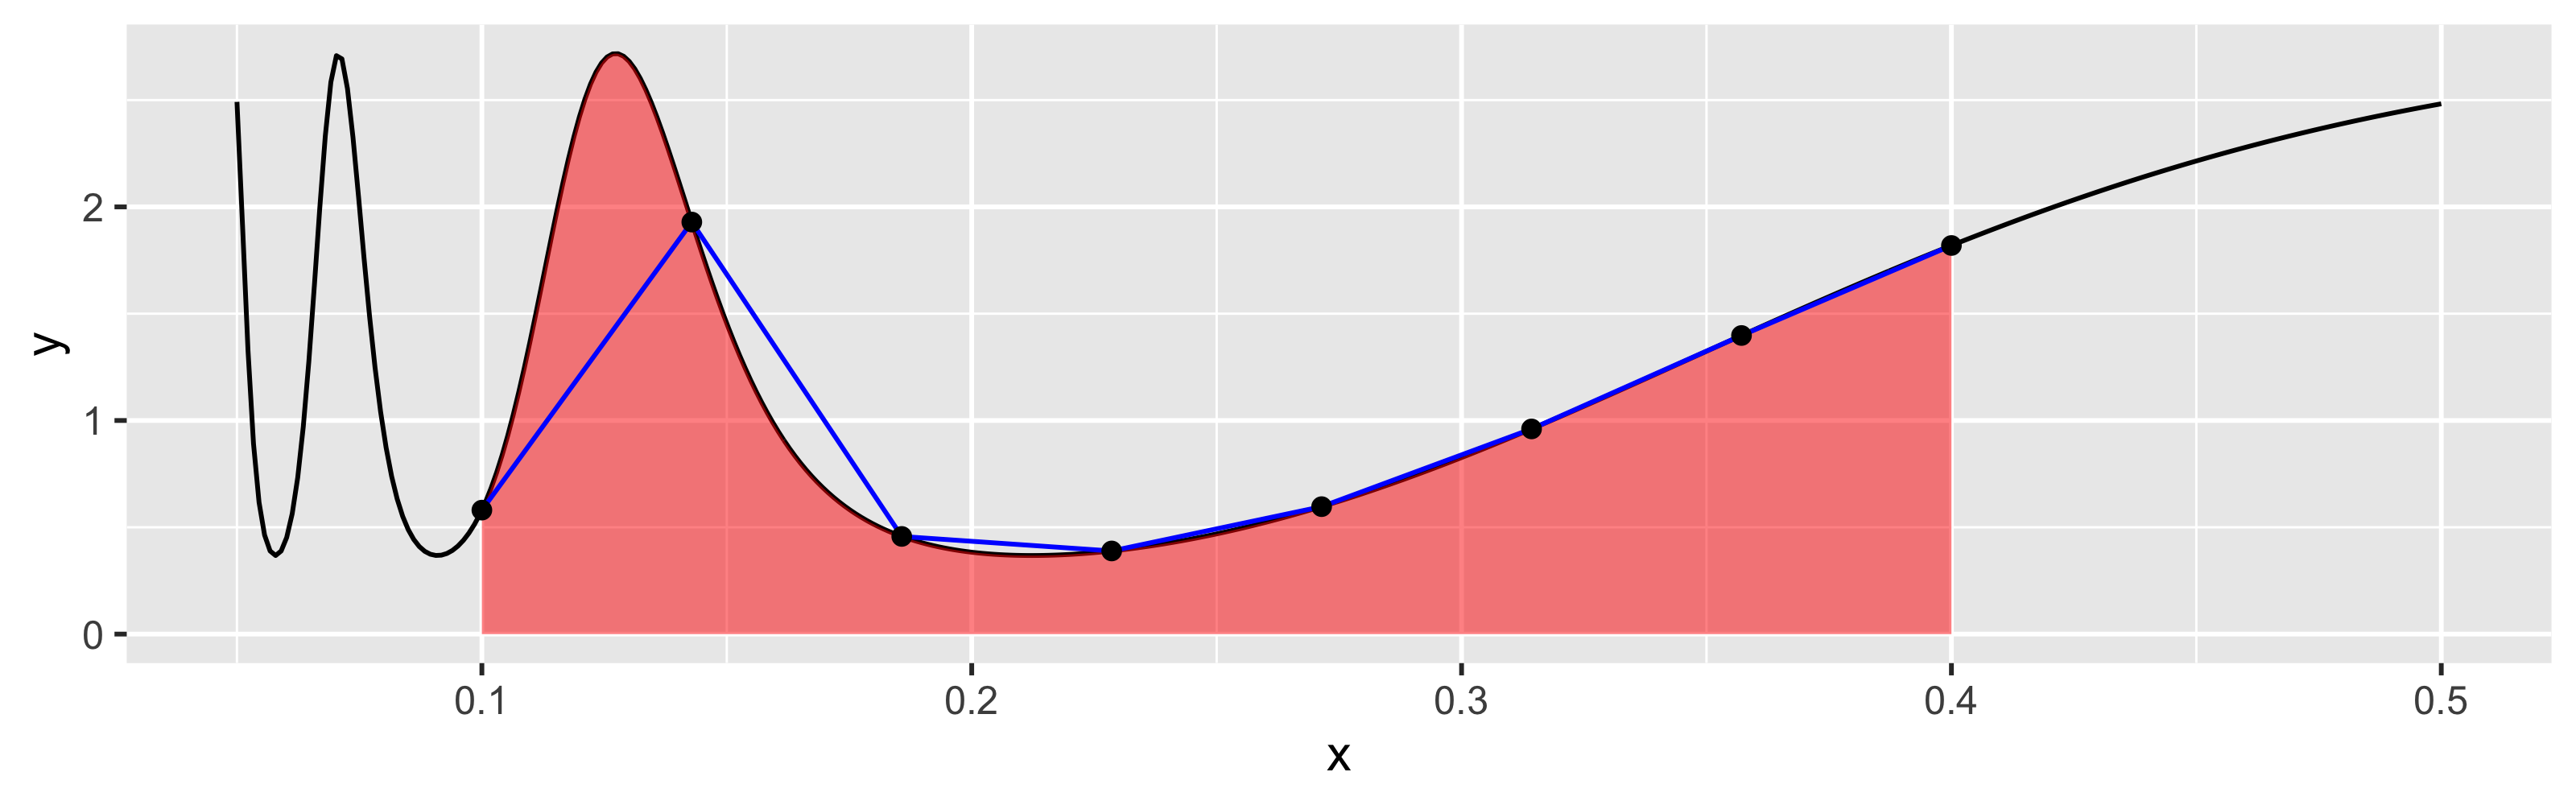

In [12]:
N_trap_mesh <- 8

x_trapezoid_mesh <- seq(0.1, 0.4, length.out = N_trap_mesh)

trap_df <- data.frame(x_trap = x_trapezoid_mesh,
                      y_trap = example_f(x_trapezoid_mesh),
                      y_zeros = numeric(N_trap_mesh))

ggplot(gg_plot_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x_int, ymin = ymin, ymax = ymax),
        fill = "red", alpha = 0.5) +
        geom_line(data = trap_df, aes(x = x_trap, y = y_trap), color = "blue") +
        geom_point(data = trap_df, aes(x = x_trap, y = y_trap))

The previous interpolation is *linear interpolation*, there are many different types of interpolation and methods to pick the locations $x_1,\ldots,x_n$. The associate quadrature algorithm is called the *trapezium rule* because the total approximating area is built from trapeziums:

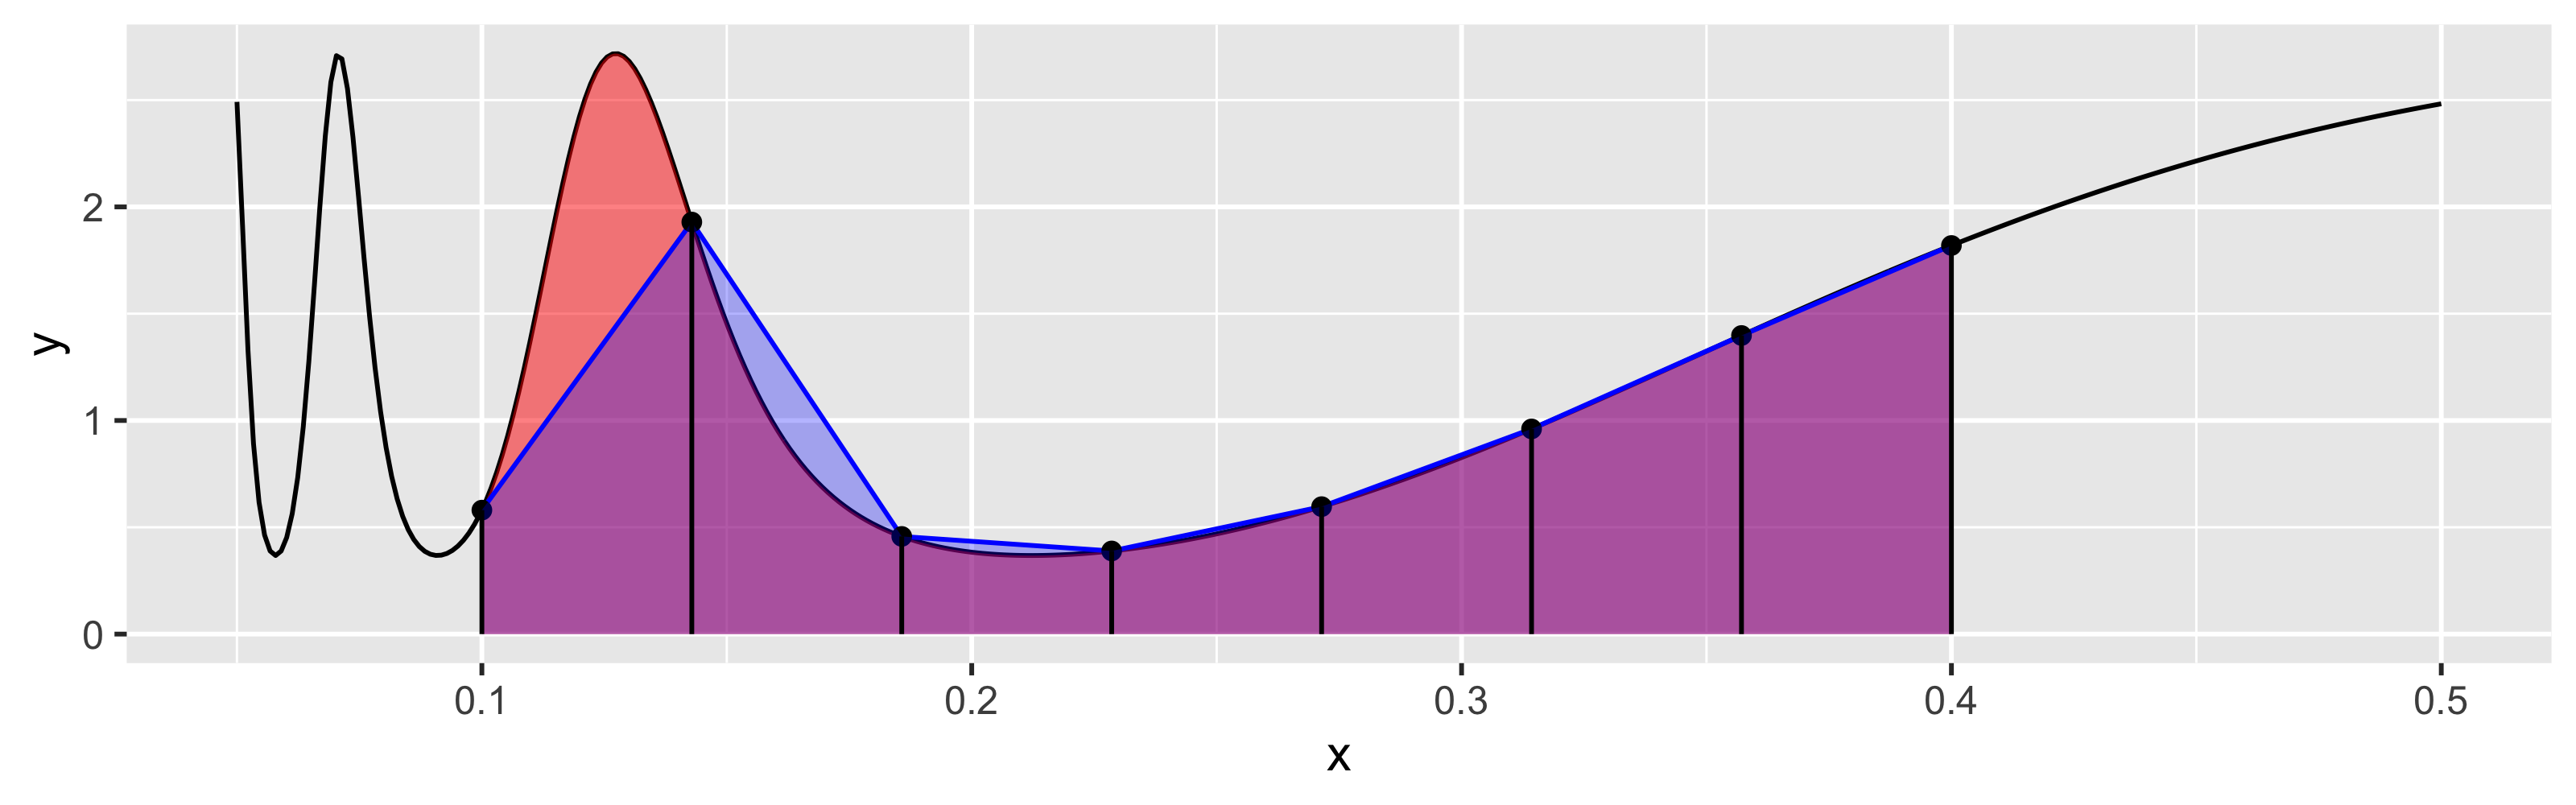

In [13]:
ggplot(gg_plot_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x_int, ymin = ymin, ymax = ymax),
        fill = "red", alpha = 0.5) +
        geom_line(data = trap_df, aes(x = x_trap, y = y_trap), color = "blue") +
        geom_point(data = trap_df, aes(x = x_trap, y = y_trap)) +
        geom_ribbon(data = trap_df, aes(x = x_trap, ymin = y_zeros, ymax = y_trap), 
        fill = "blue", alpha = 0.3) +
        geom_segment(data = trap_df, aes(x = x_trap, y = y_zeros, xend = x_trap, yend = y_trap)) 

The area of the trapezium with vertices $(x_i,0), (x_i, f(x_i)), (x_{i+1},f(x_{i+1})), (x_{i+1},0)$ is
$$ \frac{f(x_{i+1}) + f(x_i)}{2} (x_{i+1}-x_i).$$
Summing over all the individual trapezium areas yields the (composite) trapezium rule:
$$ \text{Trap}(f, a, b, n) = \frac{1}{2}\sum_{i=1}^{n-1} (f(x_{i+1}) + f(x_i))(x_{i+1}-x_i), $$
where $x_1 = a$ and $x_n = b$.

All standard integration routines in Python (such as ``scipy.quad``) and in ``R`` (such as), provide implementations of quadrature algorithms similar in spirit to the trapezium rule. Albeit, more advanced and better in most situations! For more advanced examples of quadrature see [Simpson's rule](https://en.wikipedia.org/wiki/Simpson%27s_rule) or [Gaussian Quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature).

#### Implementing the Trapezium Rule

Let's implement the trapezium rule! The following function ``trapezium_rule`` approximates the integral of a univariate function ``f`` from ``a`` to ``b`` using the trapezium rule over a uniform mesh of ``n`` evaluations (with default ``n=50`` used).

In [14]:
trapezium_rule <- function(f, a, b, n = 50) {
    x_mesh <- seq(a, b, length.out = n) # define the mesh
    x_diffs <- tail(x_mesh, n - 1) - head(x_mesh, n - 1)
    eval_f <- f(tail(x_mesh, n - 1)) + f(head(x_mesh, n - 1))
    output <- 0.5 * eval_f * x_diffs
    return(sum(output))
}

To check our implementation is correct we can check our quadrature result agrees with [Wolfram Alpha](https://www.wolframalpha.com/input/?i=integrate+exp%28sin%281%2Fx%29%29+from+x%3D0.1+to+x%3D0.4). Note that Wolfram Alpha uses a quadrature routine to approximate this integral too, since it is unavailable in closed form.

In [15]:
print(trapezium_rule(example_f, 0.1, 0.4, n = 20000))

[1] 0.3156132


#### Using the Trapezium Rule to Compute the Posterior Mean

Recall that we want to compute the following 

$$ \mathbb{E}[\theta | \underline{y}] = \int_{\Theta} \theta \frac{p(\underline{y}|\theta)p(\theta)}{\int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta  }\, \mathrm{d}\theta =  \underbrace{\frac{1}{\int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta}}_{1/C}\int_{\Theta} \theta \underbrace{p(\underline{y}|\theta)p(\theta)}_{\text{Unnormalised Posterior}} \, \mathrm{d}\theta. $$

Therefore, to compute the posterior mean, we need to evaluate two integrals:

$$ \text{Integral 1: } \int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta = \int_{0}^\infty p(\underline{y}|\lambda)p(\lambda)\,\mathrm{d}\lambda . $$

$$ \text{Integral 2: }  \int_{\Theta} \theta p(\underline{y}|\theta)p(\theta) \, \mathrm{d}\theta = \int_{0}^{\infty} \lambda p(\underline{y}|\lambda)p(\lambda) \, \mathrm{d}\lambda . $$

The trapezium really only works for finite limits $a$ and $b$ ($\int_a^b f(x)\mathrm{d}x$). The lower limit will be $a=0$ and we will just use a large number $ b \gg 0$ for the upper limit. 

In order to use the trapezium rule, we need to implement the integrand of the second integral (the function $\lambda \mapsto \lambda p(\underline{y}|\lambda)p(\lambda)$). We also need to perform [currying](https://en.wikipedia.org/wiki/Currying) to turn our functions into the form that ``trapezium_rule`` expects, we will use the ``y_data`` and ``prior_params`` we defined earlier. In the following, ``integrand_1`` is the integrand of the first integral (computation of the normalisation constant $C$), and ``integrand_2`` is the integrand of the second integral. Note that ``integrand_2`` is just the output of ``integrand_1`` multipled by ``lambda``:

In [16]:
integrand_1 <- function(lambda) (dposterior(lambda, y_data, prior_params))
integrand_2 <- function(lambda) (lambda * integrand_1(lambda))

We are now ready to use our trapezium rule methodology:

In [17]:
integral_1 <- trapezium_rule(integrand_1, 0.0000001, 500, 1000)
integral_2 <- trapezium_rule(integrand_2, 0.0000001, 500, 1000)

posterior_mean_trap <- integral_2 / integral_1

print(integral_1)
print(integral_2)
print(posterior_mean_trap)

[1] 0.002888172
[1] 0.01373187
[1] 4.75452


## Monte-Carlo Integration

The remaining numerical methods we will explore are all instances of Monte-Carlo integration and so I thought it would be best to have a brief introduction to this. First off, let's clarify a potential confusion:

1. Markov Chain Monte Carlo (MCMC) is a class of numerical methods that aim to sample from a given probability distribution $\mathbb{P}$ (e.g. a posterior distribution) using a Markov Chain.
2. Monte-Carlo Integration is a class of numerical methods that rely on random samples to approximate integrals. The relationship with MCMC is that you are able to use the samples obtained from MCMC to perform Monte-Carlo integration.

Monte Carlo integration is a method of integration that relies on random samples and the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers). Suppose your integration problem can be written as an expectation

$$ \mathbb{E}[f(X)] = \int f(x) p(x)\,\mathrm{d}x, $$

where $X\sim \mathbb{P}$, with density function $p(x)$. If not, you can usually rewrite your integral as an expectation, using a "reweighting trick":

$$ \int g(x)\,\mathrm{d}x = \int \frac{g(x)}{p(x)} p(x)\, \mathrm{d}x = \mathbb{E}\left[\frac{g(X)}{p(X)}\right], $$

where $X \sim \mathbb{P}$ with density function $p(x)$. Then, for an IID sample $X_1,\ldots,X_n$, the arithmetic mean of the $f(X_i)$ forms an approximation to the true expectation:

$$ \mathbb{E}[f(X)] \approx \frac{1}{n}\sum_{i=1}^n f(X_i). $$

By the law of large numbers, this approximation gets better and better as we observe more data and converges to the true value. 

### Example: Monte-Carlo Integration

Let's integrate the function used in the Trapezium rule example using Monte-Carlo. Recall the quantity of interest was the following

$$ I = \int_{0.1}^{0.4} \exp(\sin(1/x)) \mathrm{d}x. $$

In order to use Monte-Carlo integration we have to include a density function $p(x)$ so that $I$ takes the form of an expectation. The easiest way of doing this is to integrate against the density of the uniform distribution, $\text{Unif}(0.1,0.4)$. The density function is $p(x) = 1 / (0.4-0.1) = 10/3$ when $x \in [0.1,0.4]$ and $0$ elsewhere. In order to introduce this density function $p$ into the integrand of $I$, we also need to divide by it to maintain equality: 

$$ I = \int_{0.1}^{0.4} \frac{\exp(\sin(1/x))}{p(x)} p(x) \mathrm{d}x = \frac{3}{10} \int_{0.1}^{0.4} \exp(\sin(1/x))\frac{10}{3} \mathrm{d}x = \frac{3}{10}\mathbb{E}\left[\exp(\sin(1/X))\right], $$

where $X\sim \text{Unif}(0.1,0.4)$. 

Therefore, we can now approximate $I$ using Monte-Carlo integration, as

$$ I \approx \frac{3}{10} \left(\frac{1}{n}\sum_{i=1}^n \exp(\sin(1/X_i))\right), $$

where each $X_i \sim \text{Unif}(0.1,0.4)$. 

Let's implement this and visualise what is going on:



In [18]:
monte_carlo_integration <- function(f, a, b, n) {
    interval_size <- b - a
    uniform_sample <- runif(n, min = a, max = b)
    f_evals <- f(uniform_sample)
    integral <- interval_size * mean(f_evals)

    output <- list(integral = integral, uniform_sample = uniform_sample)
    return(output)
}

In the above we have implemented Monte-Carlo integration to integrate a univariate function $f$ from $x=a$ to $x=b$ using $n$ uniform samples from the distribution $\text{Unif}(a,b)$. 

Let's now visualise this, using our example function:

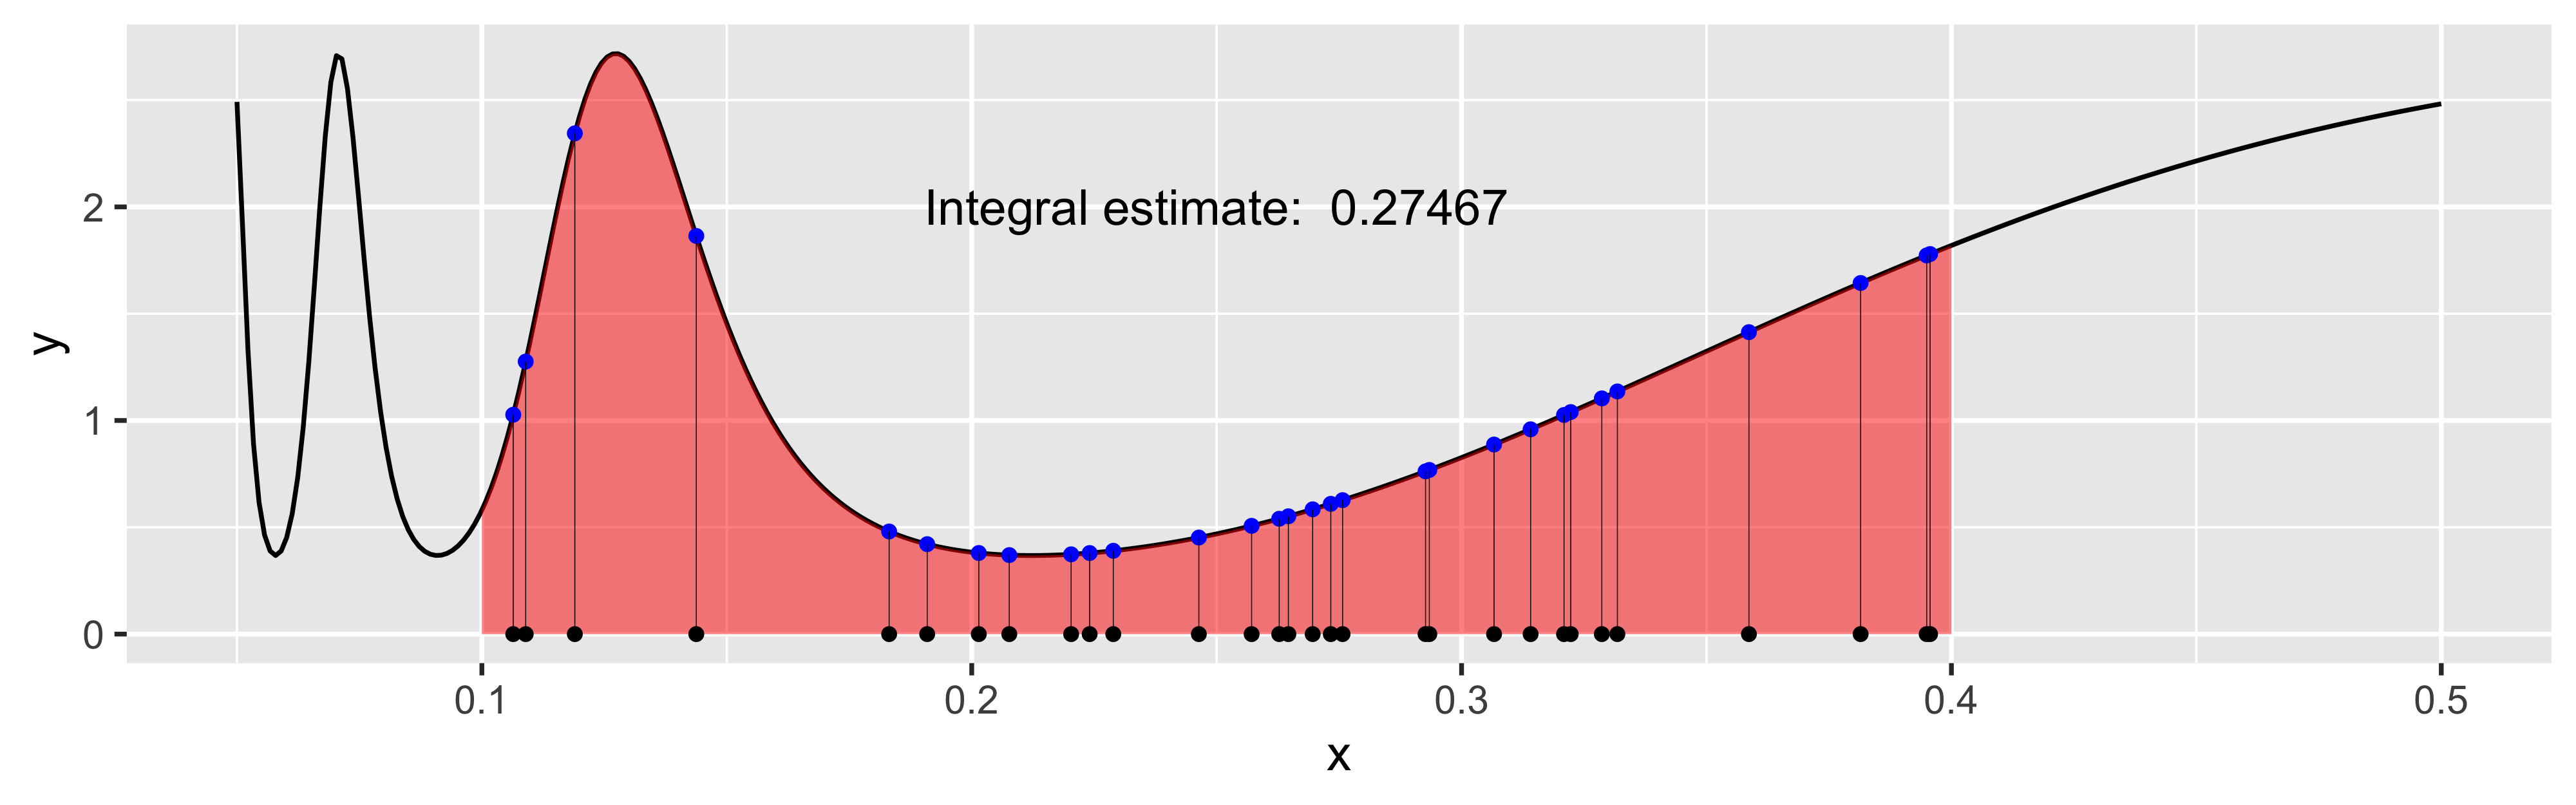

In [19]:
options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 500)

N_monte_carlo <- 30

monte_carlo_output <- monte_carlo_integration(example_f, 0.1, 0.4, n = N_monte_carlo)
integral_estimate <- monte_carlo_output$integral
integral_sample <- monte_carlo_output$uniform_sample

monte_carlo_df <- data.frame(x_monte = integral_sample,
                      y_monte = example_f(integral_sample),
                      y_zeros = numeric(N_monte_carlo))

ggplot(gg_plot_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x_int, ymin = ymin, ymax = ymax),
        fill = "red", alpha = 0.5) +
        geom_point(data = monte_carlo_df, aes(x = x_monte, y = y_monte), color = "blue", size = 1) +
        geom_point(data = monte_carlo_df, aes(x = x_monte, y = y_zeros), size = 1) +
        geom_segment(data = monte_carlo_df, aes(x = x_monte, y = y_zeros, xend = x_monte, yend = y_monte), size = 0.1) +
        annotate("text", x = 0.25, y = 2, label = paste("Integral estimate: ", round(integral_estimate, digits = 5)))

### Using Monte-Carlo Integration to Compute the Posterior Mean

Recall we want to compute the following quantity

$$  \mathbb{E}[\theta | \underline{y}] = \int_{\Theta} \theta p(\theta|\underline{y})\, \mathrm{d}\theta . $$

In order to compute this in one use of Monte-Carlo integration, we need samples from the posterior distribution:

$$ \mathbb{E}[\theta | \underline{y}] \approx \frac{1}{n}\sum_{i=1}^n \theta_i, $$

where the $\theta_i$ are samples from $p(\theta|\underline{y})$. 

In the following sections, we will explore two different methods of sampling from the posterior when we only have access to the unnormalised density: *Rejection Sampling* and *Metropolis Hastings* (an MCMC method).

#### Using Monte-Carlo Integration Twice to Compute the Posterior Mean

We could, of course, use our previous approach of Monte-Carlo integration twice to compute the normalising constant and the unnormalised posterior mean:

$$ \text{Integral 1: } \int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta = \int_{0}^\infty p(\underline{y}|\lambda)p(\lambda)\,\mathrm{d}\lambda . $$

$$ \text{Integral 2: }  \int_{\Theta} \theta p(\underline{y}|\theta)p(\theta) \, \mathrm{d}\theta = \int_{0}^{\infty} \lambda p(\underline{y}|\lambda)p(\lambda) \, \mathrm{d}\lambda . $$

In this case, both integrals include the prior density $p(\theta)$ and thus are expectations (the $\theta$ term in the subscript of $\mathbb{E}_\theta$ means that $\theta$ is the random variable we are taking expectations with respect to):

$$ \text{Integral 1: } \int_\Theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta = \mathbb{E}_\theta[p(\underline{y}|\theta)], $$

$$ \text{Integral 2: } \int_\Theta \theta p(\underline{y}|\theta)p(\theta)\,\mathrm{d}\theta = \mathbb{E}_\theta[\theta p(\underline{y}|\theta)], $$

where $\theta\sim \text{LogNormal}(\mu, \sigma^2)$ is distributed according to the prior. We could, therefore, generate samples according to the prior and estimate these two quantities using Monte-Carlo integration. Let's do that:

In [20]:
monte_carlo_integration_prior <- function(f, n, prior_params) {
    mu <- prior_params$mu # assign each parameter from the vector
    sd <- prior_params$sd

    prior_sample <- rlnorm(n, mu, sd)
    f_evals <- f(prior_sample)
    integral <- mean(f_evals)

    output <- list(integral = integral, prior_sample = prior_sample)
    return(output)
}

Let's now estimate these quantities:

#### Integral 1:

Although we implemented the integrand of $\text{Integral 1}$ in the trapezium rule section as ``integrand_1``, it included the prior density as a term which we no longer want. Realising that we now want to only evaluate the likelihood function, we will use this instead:

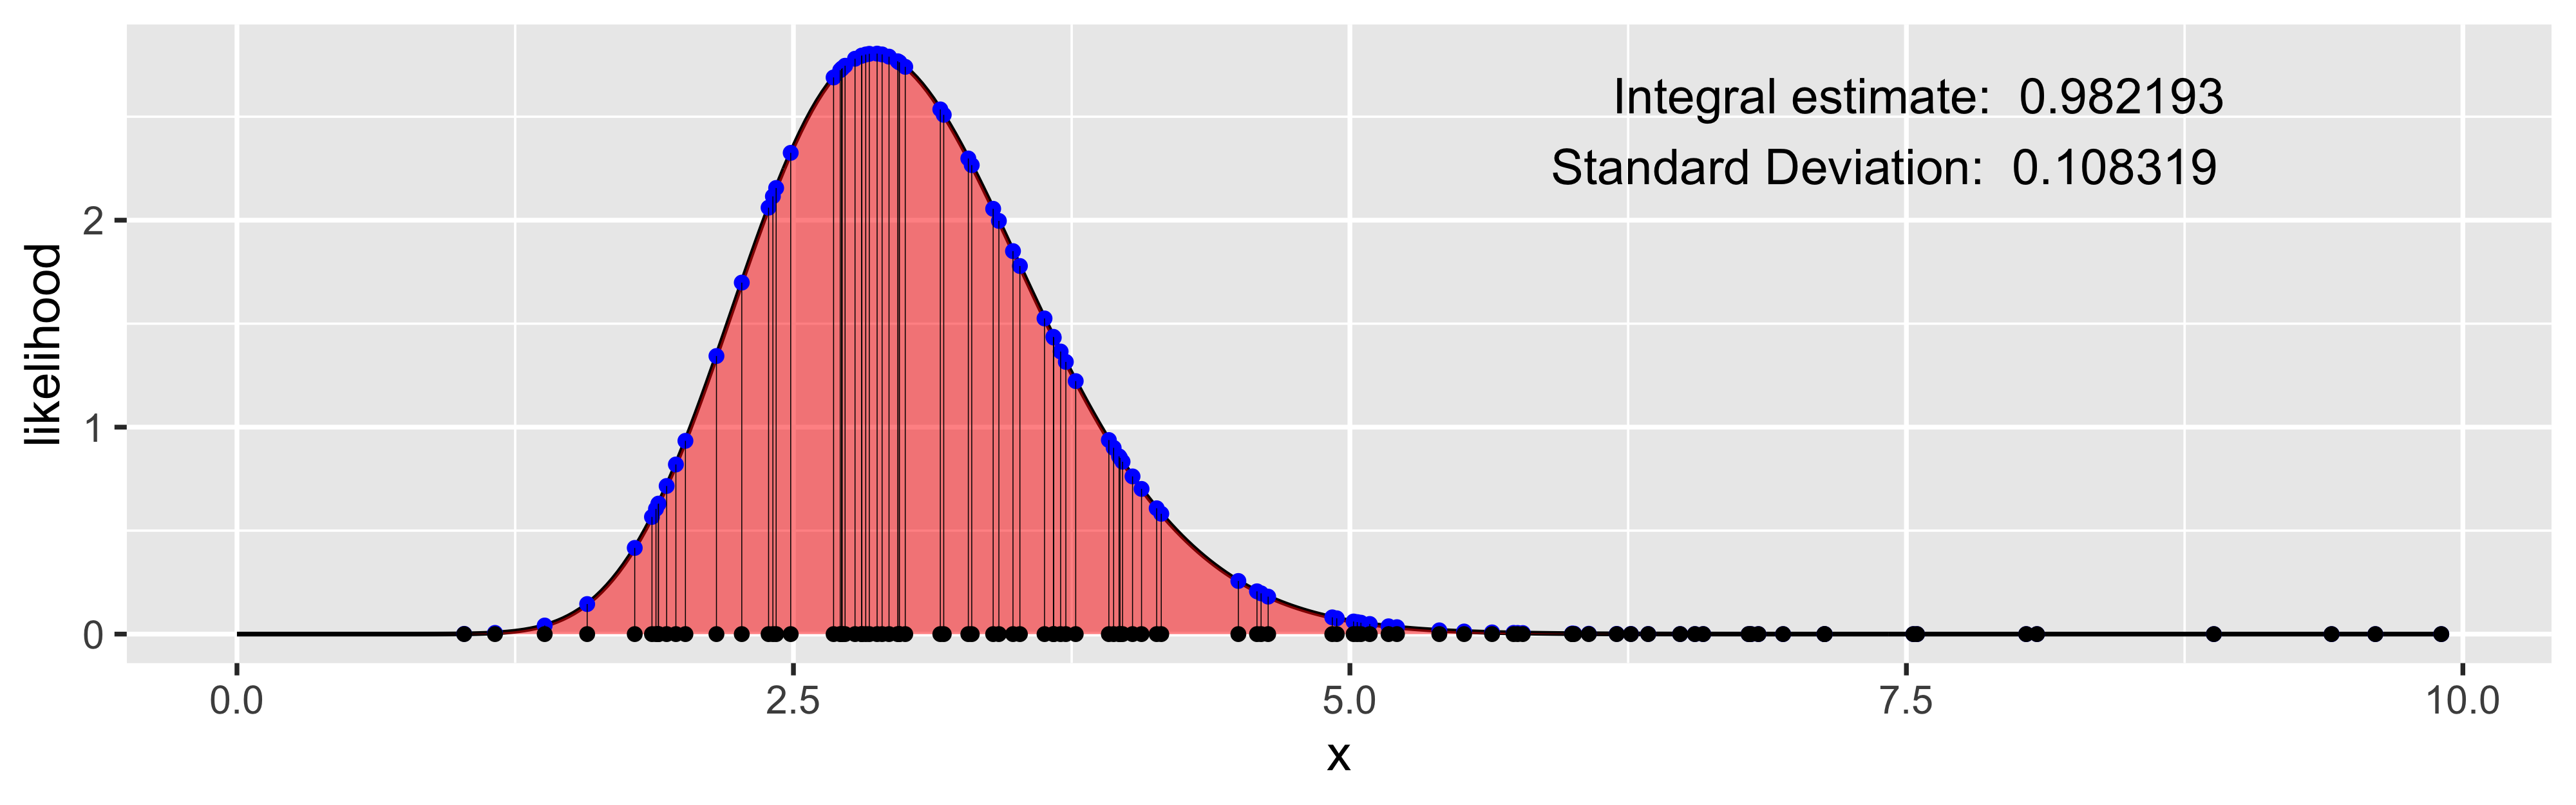

In [27]:
likelihood_integrand <- function(lambda) (dlikelihood_vectorised(y_data, lambda))

options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 500)

N_monte_carlo <- 100

monte_carlo_output <-  monte_carlo_integration_prior(likelihood_integrand, N_monte_carlo, prior_params)
integral_estimate <- monte_carlo_output$integral
integral_sample <- monte_carlo_output$prior_sample
likelihood_sample <- likelihood_integrand(integral_sample)

lambda_mesh <- seq(0, max(integral_sample), length.out = 400)
likelihood_df <- data.frame(x = lambda_mesh, likelihood = likelihood_integrand(lambda_mesh),
                        ymin = numeric(400))

monte_carlo_df_likelihood <- data.frame(x_monte = integral_sample,
                             y_monte = likelihood_sample,
                             y_zeros = numeric(N_monte_carlo))

ggplot(likelihood_df) + geom_line(aes(x = x, y = likelihood)) +
        geom_ribbon(aes(x = lambda_mesh, ymin = ymin, ymax = likelihood),
        fill = "red", alpha = 0.5) +
        geom_point(data = monte_carlo_df_likelihood, aes(x = x_monte, y = y_monte), color = "blue", size = 1) +
        geom_point(data = monte_carlo_df_likelihood, aes(x = x_monte, y = y_zeros), size = 1) +
        geom_segment(data = monte_carlo_df_likelihood, aes(x = x_monte, y = y_zeros, xend = x_monte, yend = y_monte), size = 0.1) +
        annotate("text", x = Inf, y = Inf, hjust = 1.5, vjust = 1.5,
                 label = paste("Integral estimate: ", round(integral_estimate, digits = 7), 
                               "\nStandard Deviation: ", round(sqrt(var(likelihood_sample) / N_monte_carlo), digits=7)))

#### Integrand 2:

Let's do the same thing with the second integrand:

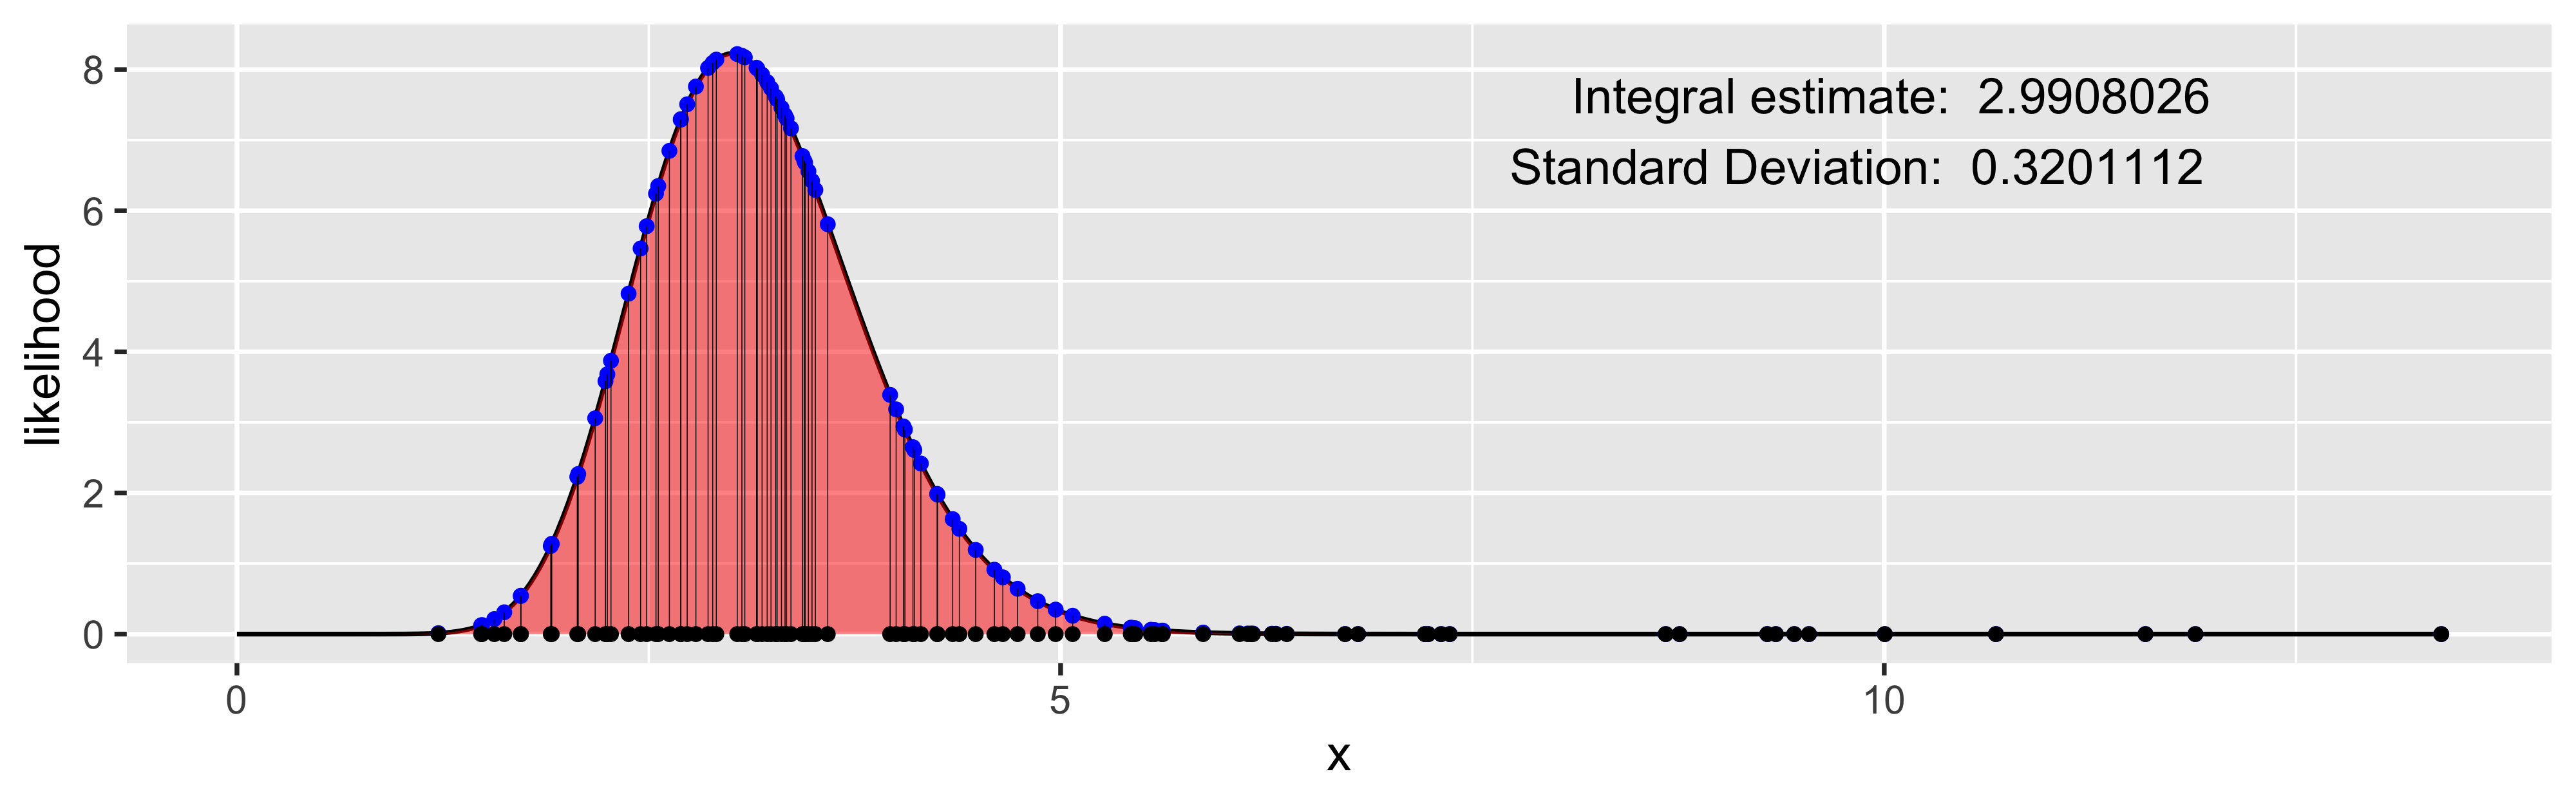

In [28]:
lambda_likelihood <- function(lambda) (lambda * dlikelihood_vectorised(y_data, lambda))

options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 500)

N_monte_carlo <- 100

monte_carlo_output <-  monte_carlo_integration_prior(lambda_likelihood, N_monte_carlo, prior_params)
integral_estimate <- monte_carlo_output$integral
integral_sample <- monte_carlo_output$prior_sample
lambda_likelihood_sample <- lambda_likelihood(integral_sample)

lambda_mesh <- seq(0, max(integral_sample), length.out = 400)
likelihood_df <- data.frame(x = lambda_mesh, likelihood = lambda_likelihood(lambda_mesh),
                        ymin = numeric(400))

monte_carlo_df_likelihood <- data.frame(x_monte = integral_sample,
                             y_monte = lambda_likelihood_sample,
                             y_zeros = numeric(N_monte_carlo))

ggplot(likelihood_df) + geom_line(aes(x = x, y = likelihood)) +
        geom_ribbon(aes(x = lambda_mesh, ymin = ymin, ymax = likelihood),
        fill = "red", alpha = 0.5) +
        geom_point(data = monte_carlo_df_likelihood, aes(x = x_monte, y = y_monte), color = "blue", size = 1) +
        geom_point(data = monte_carlo_df_likelihood, aes(x = x_monte, y = y_zeros), size = 1) +
        geom_segment(data = monte_carlo_df_likelihood, aes(x = x_monte, y = y_zeros, xend = x_monte, yend = y_monte), size = 0.1) +
        annotate("text", x = Inf, y = Inf, hjust = 1.5, vjust = 1.5,
                 label = paste("Integral estimate: ", round(integral_estimate, digits = 7), 
                               "\nStandard Deviation: ", round(sqrt(var(lambda_likelihood_sample) / N_monte_carlo), digits=7)))

The main way of measuring the "error" of our Monte-Carlo estimator is the variance:

$$ \text{Var}\left[\frac{1}{n}\sum_{i=1}^n f(X_i)\right] = \frac{1}{n}\text{Var}[f(X)].$$

This is a measure of the variability of the Monte-Carlo estimator: how much do our integral estimates vary when we call our ``monte_carlo_integration`` functions. The variance is driven entirely by the variance of the random variable $f(X)$. In most situations, we are unable to compute this variance, but we are able to estimate it using the sample variance:

$$ \frac{1}{n}\text{Var}[f(X)] \approx \frac{1}{n}\left(\frac{1}{n-1} \sum_{i=1}^n \left(f(x_i) - \overline{f(\underline{x})}\right)^2\right),  $$

where $\overline{f(\underline{x})} = \frac{1}{n}\sum_{i=1}^n f(x_i)$ is the sample mean of the $f(x_i)$ and each $x_i$ is a sample from the distribution of $X$. 

This sample standard deviation (square root of the variance) of the Monte-Carlo estimator is what is is reported in the previous Monte-Carlo integration plots.

## Rejection Sampling

The first method we will explore to directly sample from the posterior distribution is *rejection sampling*. This methodology is really only practical for low-dimensional distributions, hence why MCMC is more generally used. A key advantage, however, is that the samples obtained through rejection sampling will be uncorrelated.

Suppose we have a positive function $g(x)$ (positive means $g(x) > 0$ for every $x$) that has a finite integral (an unnormalised probability density function, think the unnormalised posterior): 

$$ c = \int_{-\infty}^\infty g(x) \,\mathrm{d}x.$$

Then the function $p(x) = g(x)/c$ is a valid probability density function, since $p(x) > 0$ and

$$ \int_{-\infty}^\infty p(x) \,\mathrm{d}x = \frac{1}{c}\int_{-\infty}^\infty g(x) \,\mathrm{d}x = \frac{c}{c} = 1. $$

Rejection sampling allows us to, given an unnormalised probability density function $g(x)$, generate samples distributed according to the density function $p(x) = g(x)/c$. 

To properly understand rejection sampling, we first need to understand how to sample uniformly in a region enclosed by a function:

### Sampling Uniformly in a Region

Suppose we have the following probability density function $p(x)$:

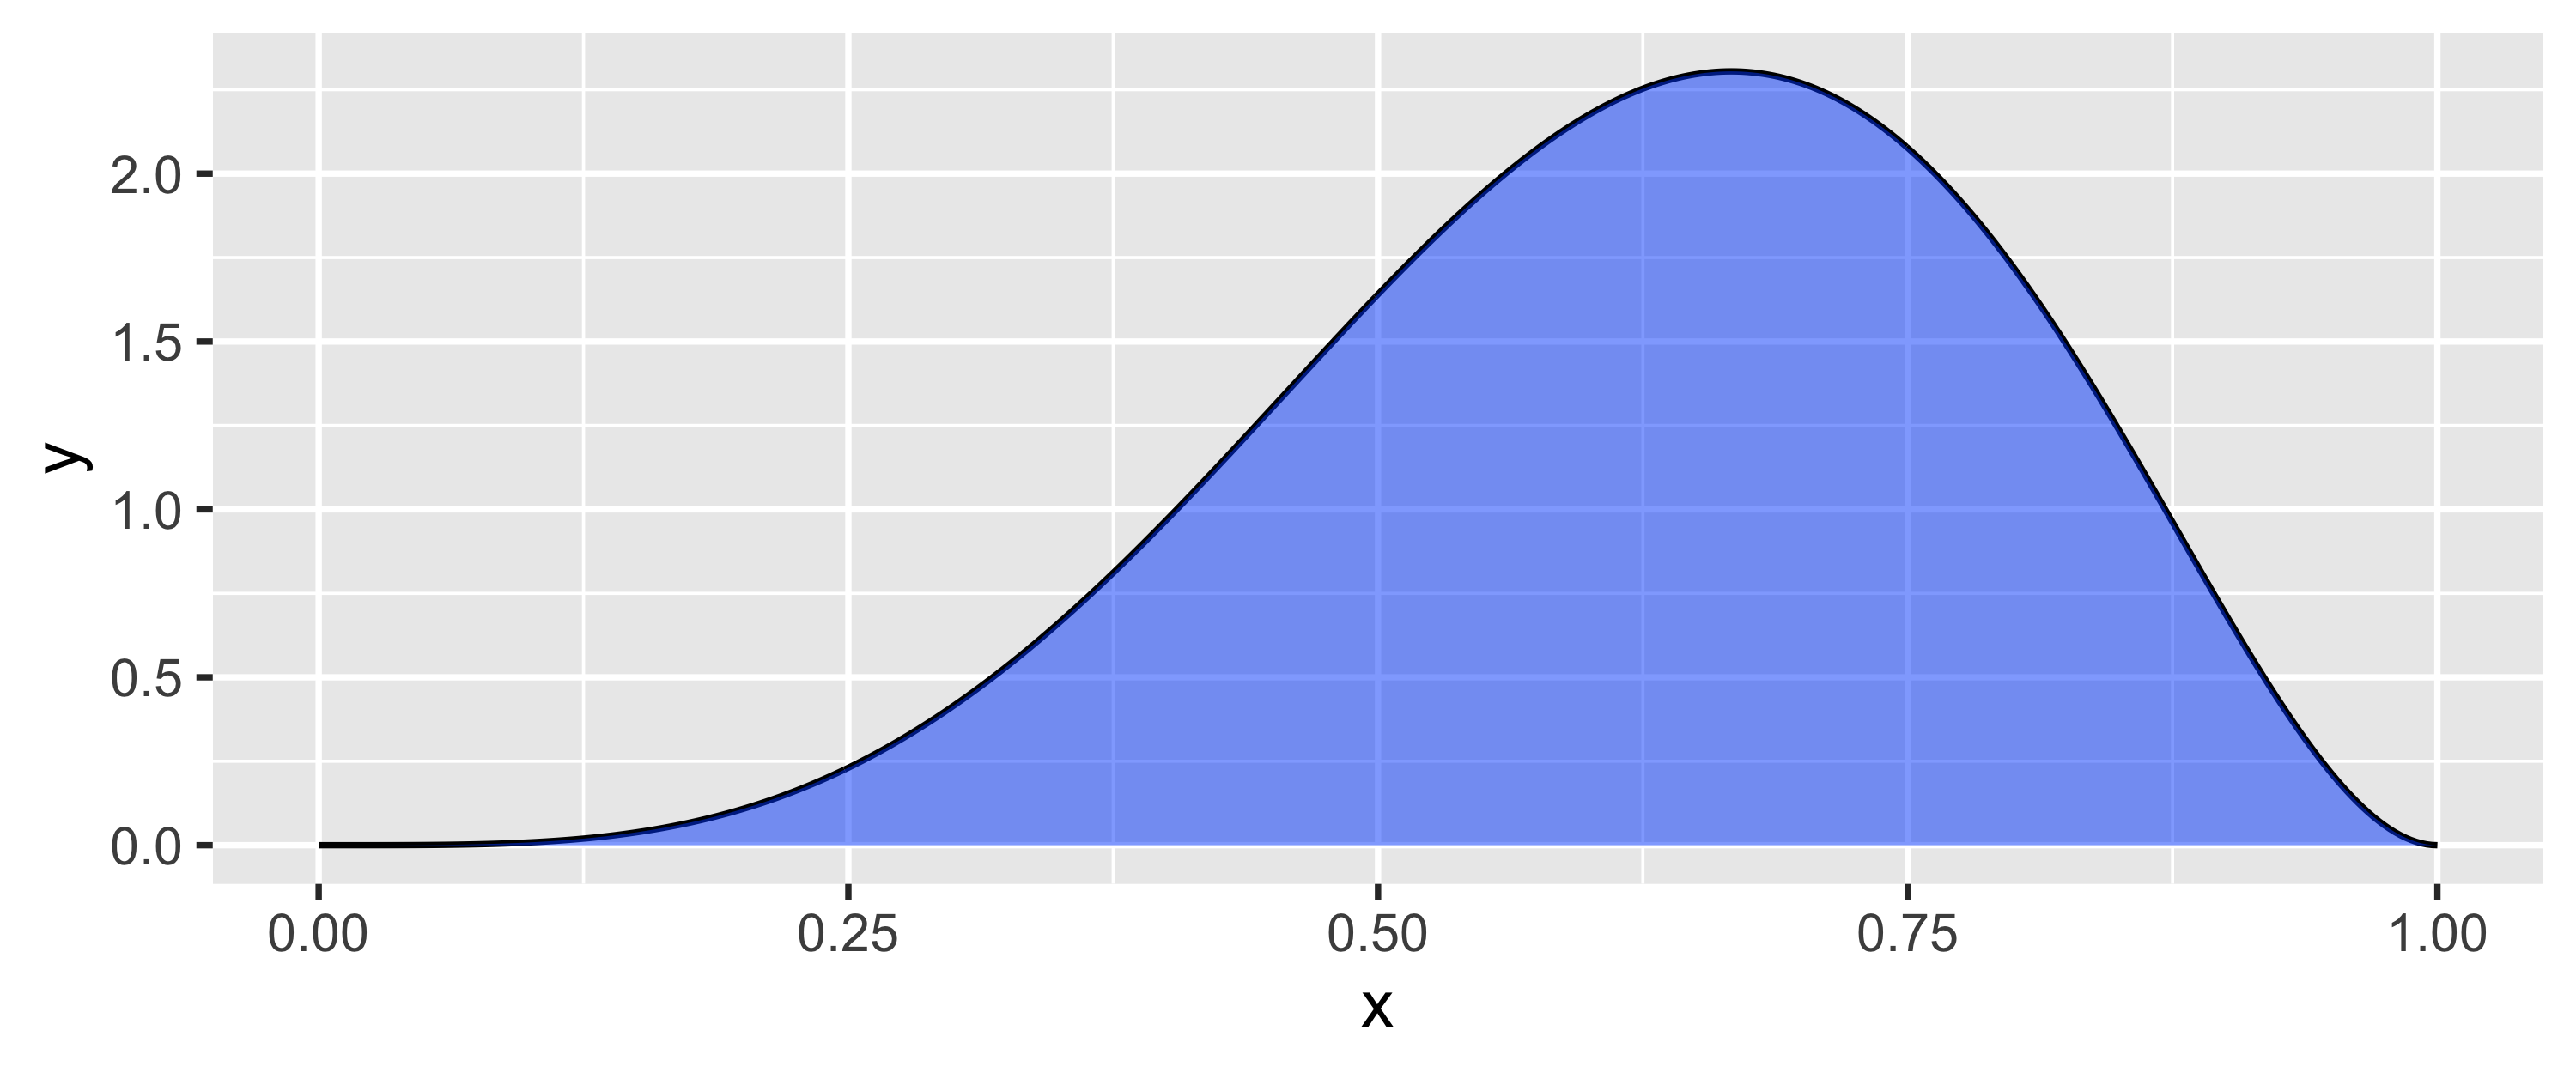

In [29]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 500)

example_density <- function(x) {
    dbeta(x, 5, 3)
    }

x_mesh <- seq(0, 1, length.out = 400) # define x mesh
volume_df <- data.frame(x = x_mesh, y = example_density(x_mesh), ymin = numeric(400))

ggplot(volume_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x, ymin = ymin, ymax = y),
        fill = "#0050fc", alpha = 0.5)

And suppose that we want generate uniform samples in the enclosed blue region (the are beneath the density function $p(x)$). By this, we mean samples that look like:

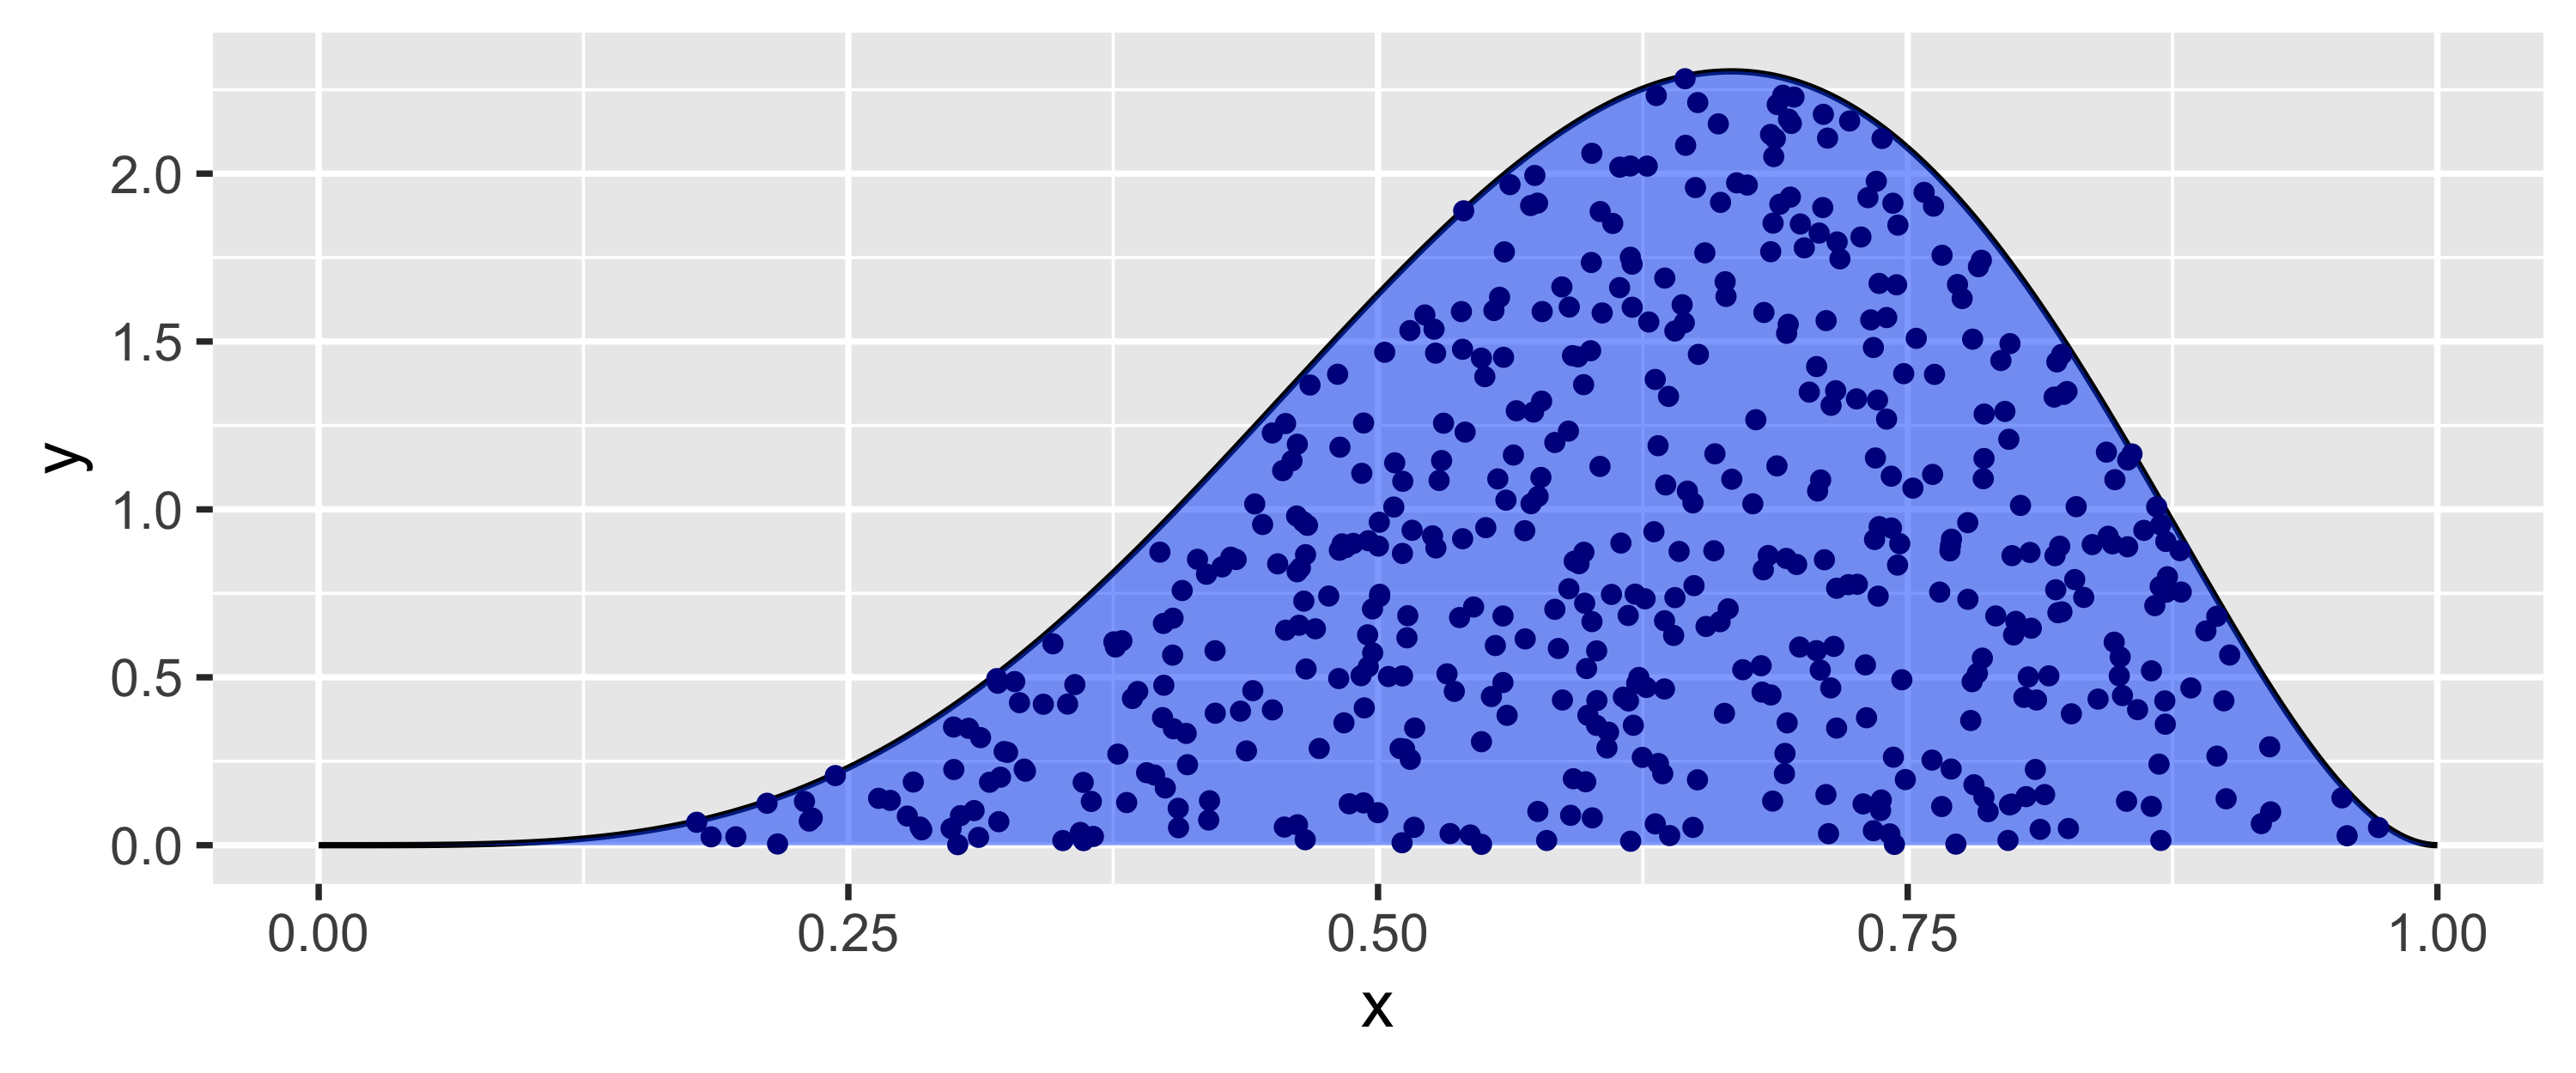

In [30]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 500)

N_plot_samples <- 500
x_samples <- rbeta(N_plot_samples, 5, 3)
y_samples <- runif(N_plot_samples, 0, 1) * dbeta(x_samples, 5, 3)
sample_df <- data.frame(x = x_samples, y = y_samples)

ggplot(volume_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x, ymin = ymin, ymax = y),
        fill = "#0050fc", alpha = 0.5) +
        geom_point(data = sample_df, aes(x = x, y = y), size = 1, color = "#01018d")

Each sample above was generated by:

1. First sampling an $x_i$ from the blue probability density function.
2. Then sampling a $u_i$ from the uniform distribution $\text{Unif}(0, p(x_i))$.
3. The pair $(x_i, u_i)$ is then uniformly distributed in the blue region enclosed by the density function.


We can also generate uniform samples in the region enclose by an unnormalised density function $g(x) = c p(x)$ (any positive function which has a finite integral):

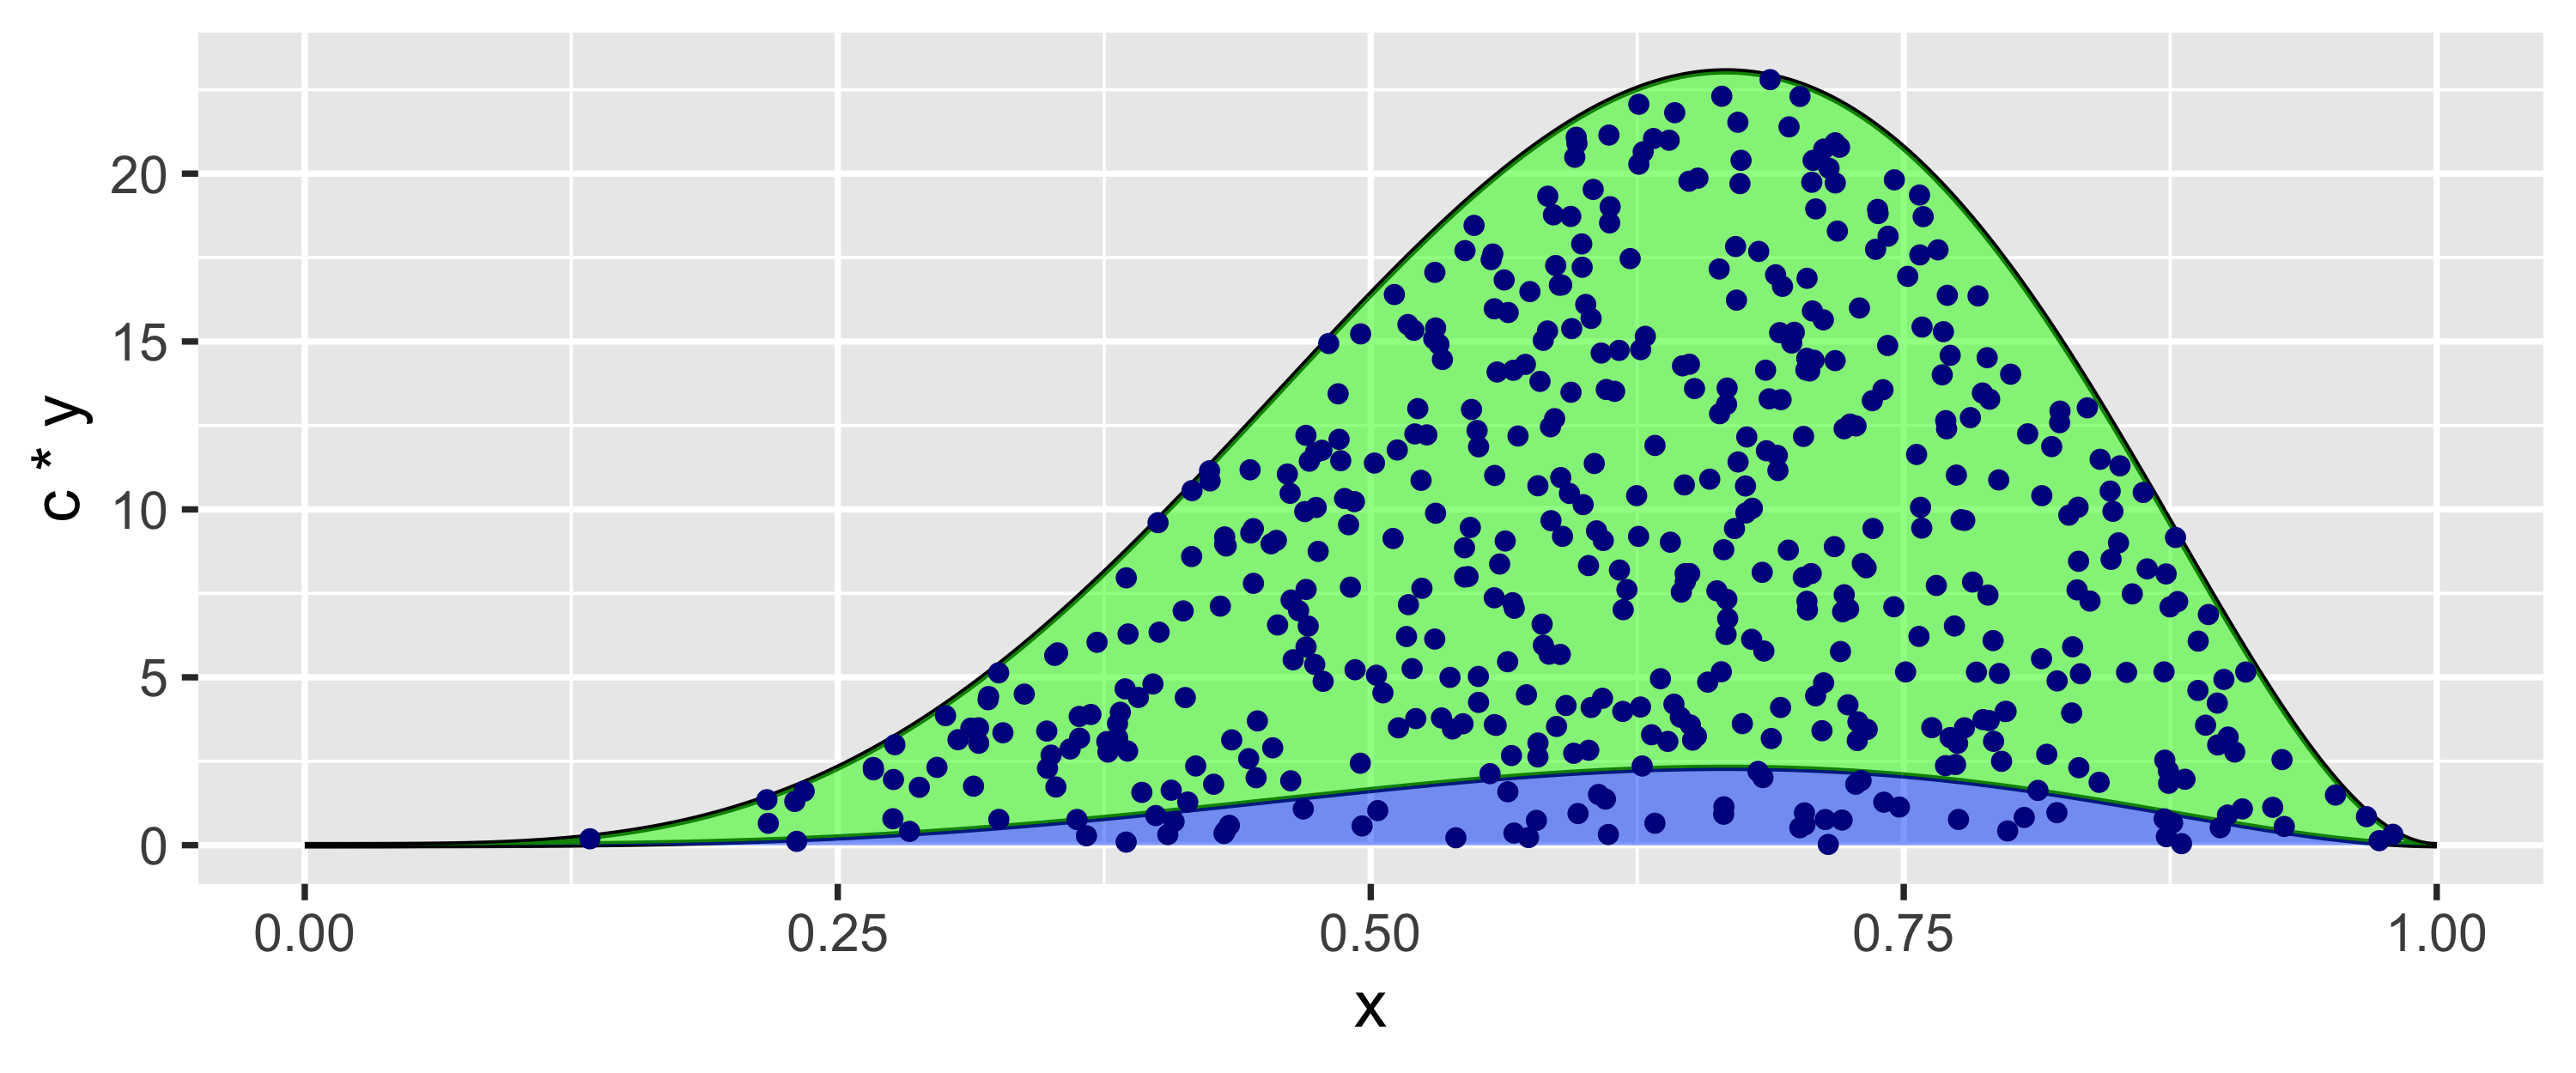

In [31]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 500)

c <- 10
N_plot_samples <- 500
x_samples <- rbeta(N_plot_samples, 5, 3)
y_samples <- c * runif(N_plot_samples, 0, 1) * dbeta(x_samples, 5, 3)
sample_df <- data.frame(x = x_samples, y = y_samples)

ggplot(volume_df) + geom_line(aes(x = x, y = c * y)) +
        geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x, ymin = y, ymax = c * y),
        fill = "green", alpha = 0.5) +
        geom_ribbon(aes(x = x, ymin = ymin, ymax = y),
        fill = "#0050fc", alpha = 0.5) +
        geom_point(data = sample_df, aes(x = x, y = y), size = 1, color = "#01018d") 

These samples were obtained analogously, the only difference being suitably scaling up the uniform samples:

1. First sampling an $x_i$ from the blue probability density function.
2. Then sampling a $u_i$ from the uniform distribution $\text{Unif}(0, g(x_i))$.
3. The pair $(x_i, u_i)$ is then uniformly distributed in the green region enclosed by $g(x)$.

### Rejection Sampling

Suppose that we are now given samples $(x_i, u_i)$ that are uniformly distributed in the region enclosed by an unnormalised probability density function $g(x) = cp(x)$. Then, by our previous sampling arguments, the samples $x_i$ are distributed according to density function $p(x)$. 

This is the basis of how rejection sampling work:

1. Generate samples $(x_i, u_i)$ that are distributed uniformly in the region enclosed by the unnormalised density function $g(x) = cp(x)$.
2. Then the samples $x_i$ are distributed according to $p(x)$

The question is then, how do we generate samples that uniformly distributed in a region without being able to generate samples from $p(x)$? This is where the "rejection" part of "rejection sampling" comes in.

The basic idea is to first generate uniform samples in an a larger region that encloses the unnormalised density function $g(x)$ and then throw away (or "reject") the samples that do not lie below $g(x)$:

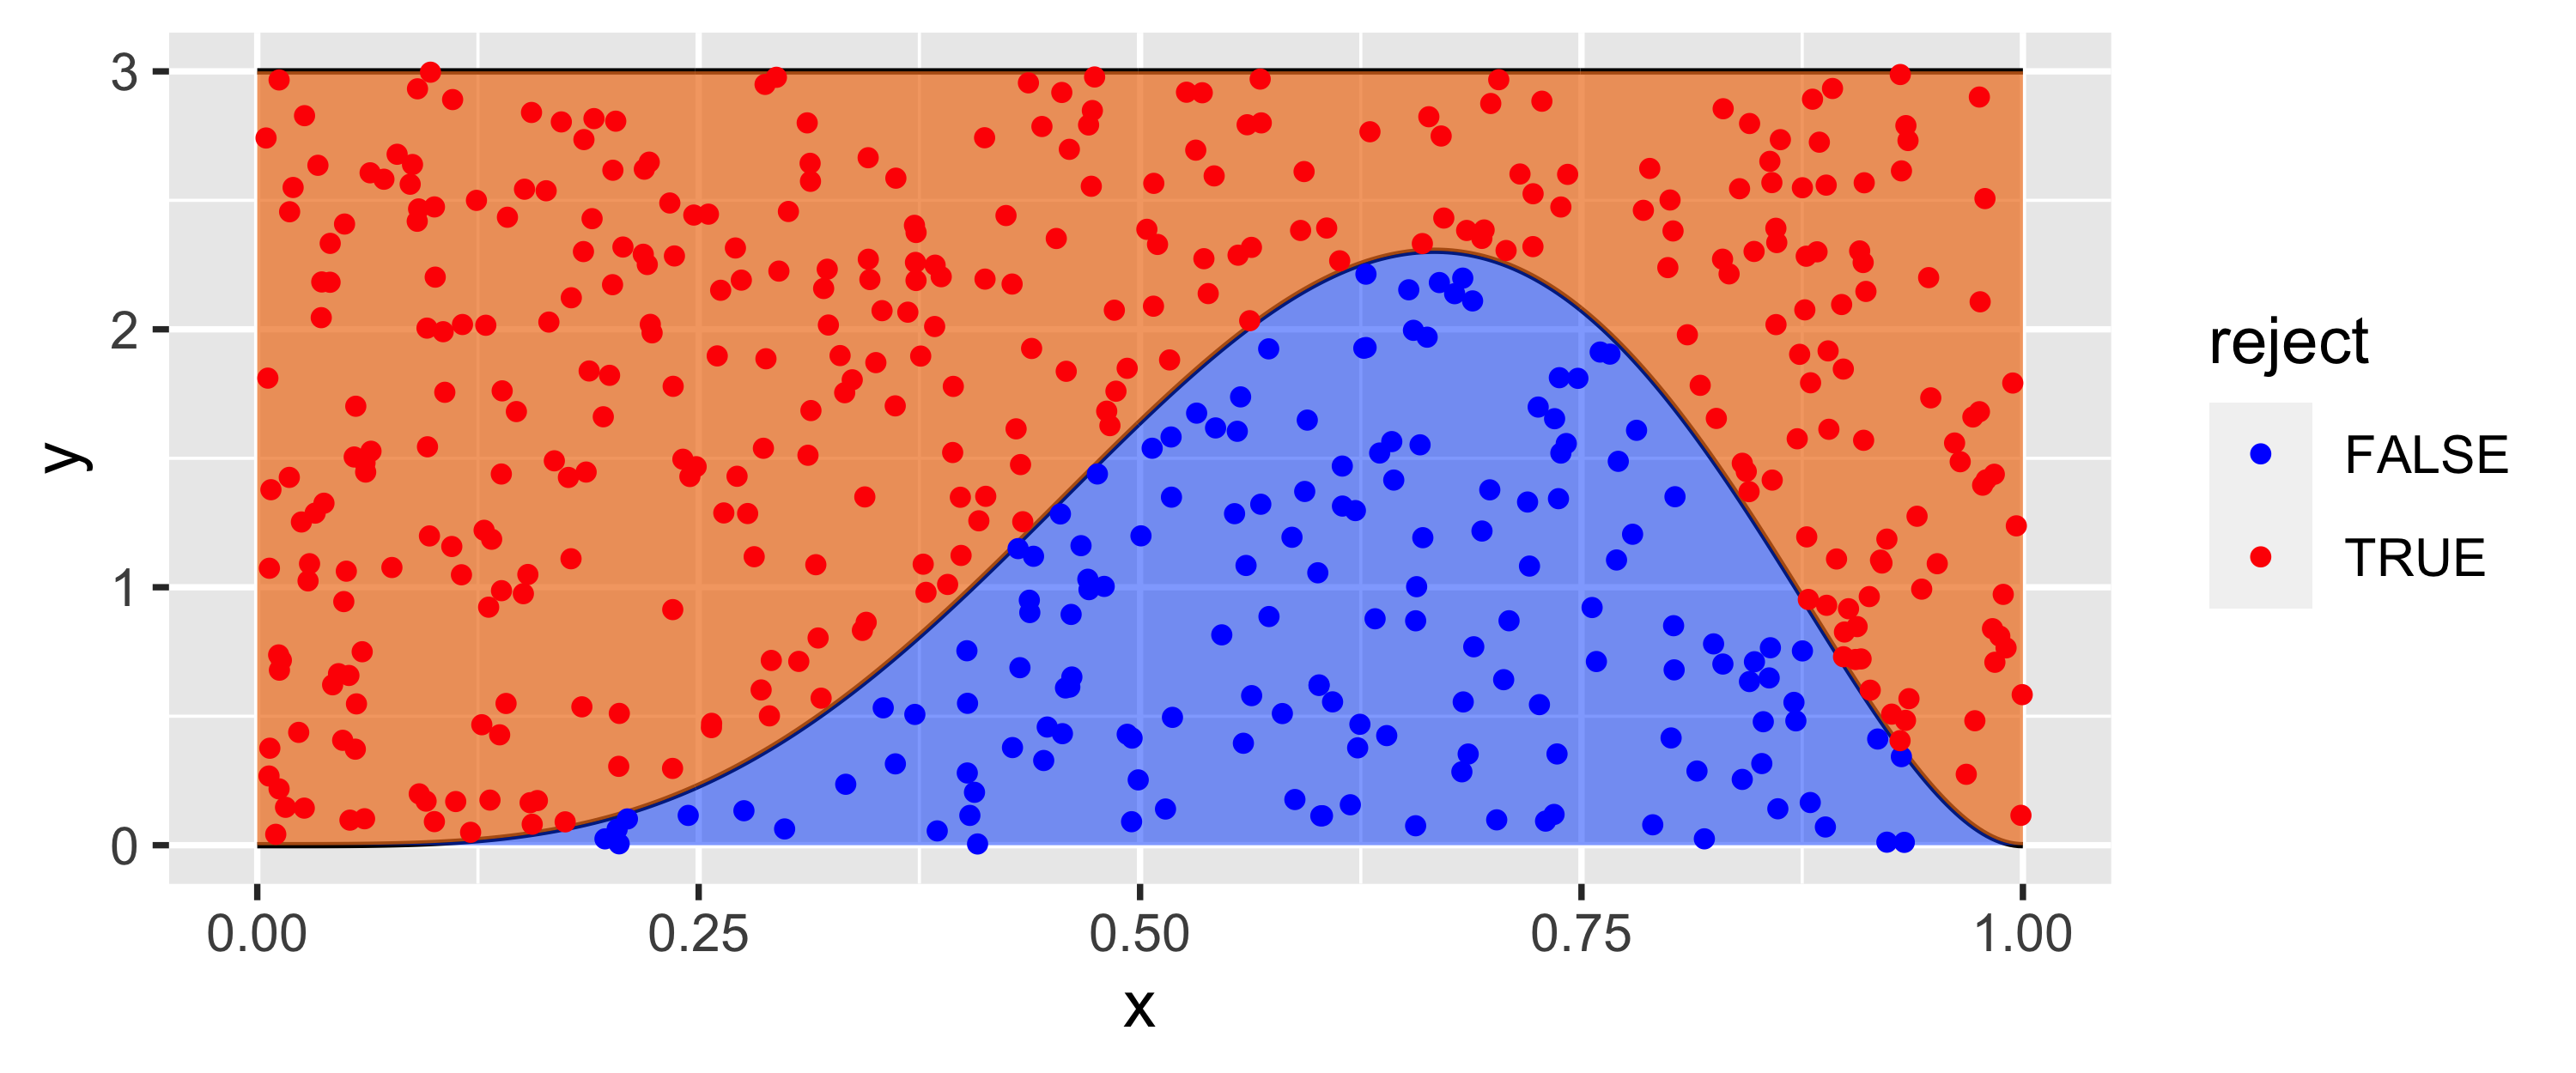

In [32]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 500)


N_plot_samples <- 500
c <- 3
x_samples <- runif(N_plot_samples, 0, 1)
y_samples <- c * runif(N_plot_samples, 0, 1)
sample_df <- data.frame(x = x_samples, y = y_samples,
                        reject = y_samples > dbeta(x_samples, 5, 3))

ribbon_df <- data.frame(x = x_mesh, ymax = numeric(400) + c, ymin = example_density(x_mesh))

ggplot(volume_df) + geom_line(aes(x = x, y = y)) +
        geom_ribbon(aes(x = x, ymin = ymin, ymax = y),
        fill = "#0050fc", alpha = 0.5) +
        geom_line(data = ribbon_df, aes(x = x, y = ymax)) +
        geom_ribbon(data = ribbon_df, aes(x = x, ymin = ymin, ymax = ymax),
        fill = "#f07e20", alpha = 0.7) +
        geom_point(data = sample_df, aes(x = x, y = y, color = reject), size = 1) +
        scale_colour_manual(values = c("blue", "red"))


More formally now, rejection sampling works as follows:

1. Identify a density function $q(x)$ which you can sample from, and a constant $k$ such that $k q(x)$ enclose $g(x) = c p(x)$. "Enclose" really means $kq(x) \geq cp(x)$ for every $x$.
2. Sample uniformly in the region enclosed by $kq(x)$ by first sampling an $x_i$ distributed according to $q$ and then sample a $u_i$ distributed according to $\text{Unif}(0, kq(x_i))$. The pairs of samples $(x_i, u_i)$ are then uniformly distributed in the region enclosed by $kq(x)$.
3. Discard the samples $(x_i , u_i)$ that are not also enclosed by $g(x)$. That is, if $u_i > g(x_i)$, then discard.
4. The remaining samples $(x_i, u_i)$ are now distributed in the region enclosed by $g(x)$ and the samples $x_i$ are distributed according to $p$.

The density function $q(x)$ is called the *enveloping* distribution, since it "envelops" the $g(x)$. There are two main issues with rejection sampling:

1. How to actually find a probability density function $q(x)$ and constant $k$ such that $kq(x)$ is larger than $cp(x)$ for every $x$.
2. How to ensure that this pair $k$ and $q(x)$ is "efficient". By this, I mean we don't have to discard too many samples.

The second issue is the reason why rejection sampling is not used in higher dimensions.

### Using Rejection Sampling to Sample from the Posterior

Let's now use rejection sampling to sample from the posterior.

We will pick $q(x)$ to be the prior, this is because the posterior usually concentrates the posterior:

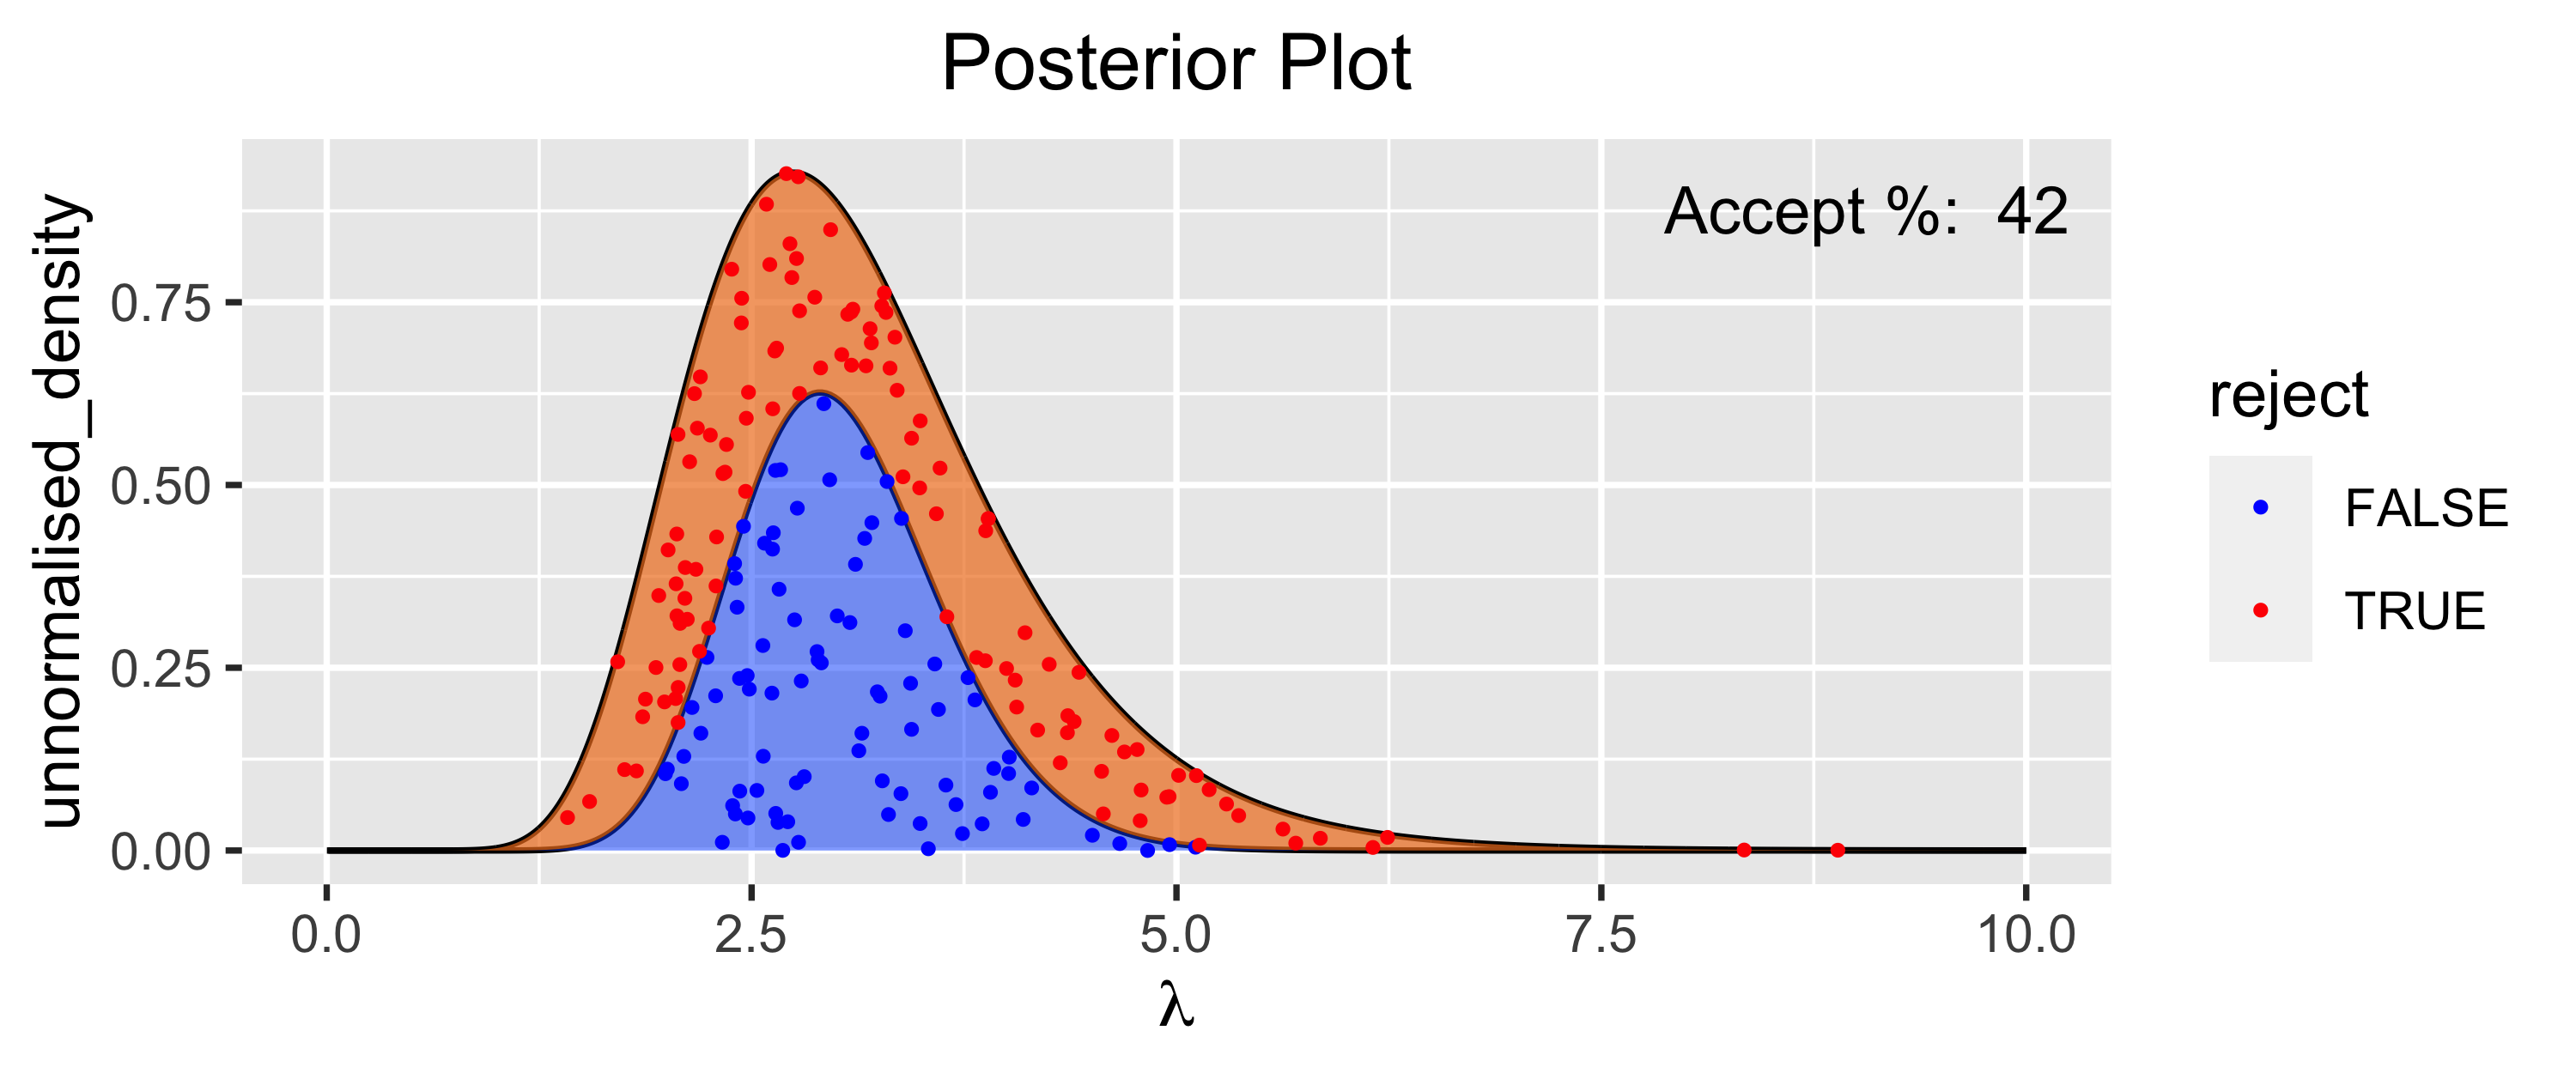

In [41]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 500)

q_params <- list(mu = log(3), sd = 0.3)
q <- function(lambda) (dlnorm(lambda, q_params$mu, q_params$sd))
sample_q <- function(n) (rlnorm(n, q_params$mu, q_params$sd))
k <- 2

mu <- prior_params$mu # assign each parameter from the vector
sd <- prior_params$sd

N_q_samples <- 200
q_samples <- sample_q(N_q_samples)
u_samples <- k * runif(N_q_samples) * q(q_samples)

lambda_mesh <- seq(0.001, max(10, max(q_samples)), length.out = 4000)
q_evals <- k * q(lambda_mesh)
posterior_evals <- dposterior(lambda_mesh, y_data, prior_params)
reject_samples <- u_samples > dposterior(q_samples, y_data, prior_params)
accept_proportion <- 1 - sum(reject_samples) / N_q_samples

q_sample_df <- data.frame(x_points = q_samples, y_points = u_samples,
                          reject = reject_samples)

line_df <- data.frame(x = lambda_mesh, y = q_evals,
                      ymin = posterior_evals,
                      fill = posterior_evals > q_evals)

ggplot(prior_like_post_df) +
        geom_line(aes(x = x, y = unnormalised_density)) +
        geom_ribbon(aes(x = x, ymin = min, ymax = unnormalised_density), fill = "#0050fc", alpha = 0.5) +
        ggtitle("Posterior Plot") +
        theme(plot.title = element_text(hjust = 0.5)) +
        xlab(expression(lambda)) +
        geom_line(data = line_df, aes(x = x, y = y)) +
        geom_ribbon(data = line_df, aes(x = x, ymin = ymin, ymax = y, fill = fill), alpha = 0.7, show.legend = FALSE) +
        scale_fill_manual(values = c("#f07e20", "#00ff00")) +
        geom_point(data = q_sample_df, aes(x = x_points, y = y_points, color = reject), size = 0.5) +
        scale_colour_manual(values = c("blue", "red")) +
        annotate("text", x = Inf, y = Inf, hjust = 1.1, vjust = 2,
                 label = paste("Accept %: ", 100 * round(accept_proportion, digits = 4)))

We obtain the "accepted" samples as follows:

In [43]:
accepted_posterior_samples <- q_samples[u_samples < dposterior(q_samples, y_data, prior_params)]
print(length(accepted_posterior_samples))

[1] 84


There are many extensions to rejection sampling, such as adaptive rejection sampling which aims to automatically find an appropriate choice of $q$ and $k$. 

### Using Rejection Sampling to Estimate the Posterior Mean

Since we now have posterior samples, we can estimate the posterior mean using Monte-Carlo integration:

$$ \mathbb{E}[\theta | \underline{y}] \approx \frac{1}{n}\sum_{i=1}^n \theta_i, $$

where the $\theta_i$ are samples from $p(\theta|\underline{y})$. 

This is really simple to compute:

In [44]:
mean(accepted_posterior_samples)

[1] 3.065789